In [1]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
USER = %env USER

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py as h5
import healpy as hp

import gc

import warnings

from fpipe.check import tsys, flux_tod

/home/ycli/code/fpipe/fpipe/check/tsys.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## **ABBA or ABAB**

Assuming power law spectrum $T(\nu) = A\nu^a$. The Taylor expasion of the power law spectrum at $\nu_0$ is:

$$
T(\nu) = T(\nu_0) + \Delta \nu T^\prime(\nu)|_{\nu_0} + \frac{1}{2}\Delta \nu^2 T^{\prime\prime}(\nu)|_{\nu_0}
$$

Given $\nu_1$, $\nu_2=\nu_1+\delta\nu$,  $\nu_3=\nu_2+\delta\nu$ and  $\nu_4=\nu_3+\delta\nu$, we have


\begin{align}
\tag{1}
T(\nu_1) &= T(\nu_2) + \frac{a}{\nu_2}T(\nu_2)\delta\nu + \frac{1}{2}\frac{a(a-1)}{\nu_2^2}T(\nu_2)\delta\nu^2 \\
\tag{2}
T(\nu_2) &= T(\nu_3) + \frac{a}{\nu_3}T(\nu_3)\delta\nu + \frac{1}{2}\frac{a(a-1)}{\nu_3^2}T(\nu_3)\delta\nu^2 \\
\tag{3}
         &= T(\nu_1) - \frac{a}{\nu_1}T(\nu_1)\delta\nu + \frac{1}{2}\frac{a(a-1)}{\nu_1^2}T(\nu_1)\delta\nu^2 \\
\tag{4}
T(\nu_3) &= T(\nu_4) + \frac{a}{\nu_4}T(\nu_4)\delta\nu + \frac{1}{2}\frac{a(a-1)}{\nu_4^2}T(\nu_4)\delta\nu^2 \\
\tag{5}
         &= T(\nu_2) - \frac{a}{\nu_2}T(\nu_2)\delta\nu + \frac{1}{2}\frac{a(a-1)}{\nu_2^2}T(\nu_2)\delta\nu^2 \\
\tag{6}
T(\nu_4) &= T(\nu_3) - \frac{a}{\nu_3}T(\nu_3)\delta\nu + \frac{1}{2}\frac{a(a-1)}{\nu_3^2}T(\nu_3)\delta\nu^2
\end{align}

### ABBA [Wang et. al MeerKAT]

\begin{align}
&\frac{1}{2}\left(T(\nu_2) + T(\nu_3)\right) - \frac{1}{2}\left(T(\nu_1) + T(\nu_4)\right) \\
& = \frac{1}{2} \left( (2) + (5) \right) - \frac{1}{2}\left((1) + (6)\right) \\
& = \left( \frac{1}{2} \left( T(\nu_3) + T(\nu_2) \right) + \frac{a}{2} \left( \frac{T(\nu_3)}{\nu_3} - \frac{T(\nu_2)}{\nu_2} \right)\delta\nu + \frac{a(a-1)}{4} \left( \frac{T(\nu_3)}{\nu_3^2} + \frac{T(\nu_2)}{\nu_2^2} \right)\delta\nu^2 \right) \\
& - \left( \frac{1}{2} \left( T(\nu_2) + T(\nu_3) \right) + \frac{a}{2} \left( \frac{T(\nu_2)}{\nu_2} - \frac{T(\nu_3)}{\nu_3} \right)\delta\nu + \frac{a(a-1)}{4} \left( \frac{T(\nu_2)}{\nu_2^2} + \frac{T(\nu_3)}{\nu_3^2} \right)\delta\nu^2 \right) \\
& = a \left( \frac{T(\nu_3)}{\nu_3} - \frac{T(\nu_2)}{\nu_2} \right)\delta\nu
\end{align}

### ABAB

\begin{align}
&\frac{1}{2}\left(T(\nu_1) + T(\nu_3)\right) - \frac{1}{2}\left(T(\nu_2) + T(\nu_4)\right) \\
& = \frac{1}{2} \left( (1) + (5) \right) - \frac{1}{2}\left((2) + (6)\right) \\
& = \left( \frac{1}{2} \left( T(\nu_2) + T(\nu_2) \right) + \frac{a}{2} \left( \frac{T(\nu_2)}{\nu_2} - \frac{T(\nu_2)}{\nu_2} \right)\delta\nu + \frac{a(a-1)}{4} \left( \frac{T(\nu_2)}{\nu_2^2} + \frac{T(\nu_2)}{\nu_2^2} \right)\delta\nu^2 \right) \\
& - \left( \frac{1}{2} \left( T(\nu_3) + T(\nu_3) \right) + \frac{a}{2} \left( \frac{T(\nu_3)}{\nu_3} - \frac{T(\nu_3)}{\nu_3} \right)\delta\nu + \frac{a(a-1)}{4} \left( \frac{T(\nu_3)}{\nu_3^2} + \frac{T(\nu_3)}{\nu_3^2} \right)\delta\nu^2 \right) \\
& = \left( T(\nu_2) - T(\nu_3) \right) + \frac{a(a-1)}{2}\left( \frac{T_2}{\nu_2^2} - \frac{T_3}{\nu_3^2} \right)\delta\nu^2
\end{align}

## **Check Tsys using TOD**

### ABBA for each data block

In [54]:
tod_path = '/home/DATA/ycli/fanalysis/rmbsl_sumfeeds_CC/'

freq_diff = 'ABBA'

ylabel_list = ['Block 01', 'Block 02', 'Block 03', 'Block 04', 'Block 05', 'Block 06', 'Block 07']
tod_suffix_list = ['arcdrift%04d-%04d'%(i+1, i+1) for i in range(7)]

tod_cent_list = ['20210302/HIMGS_1100+2600', 
                 '20210309/HIMGS_1100+2610',
                 '20210314/HIMGS_1100+2610',
                 '20210313/HIMGS_1100+2621',
                 '20210305/HIMGS_1100+2632',
                 '20210306/HIMGS_1100+2643',
                 '20210307/HIMGS_1100+2654',
                 ]

bad_beam_list = [[10,], 
                 [6, 10], [6, 10],
                 [9, 10], [],
                 [10, 17], [6,]
                ]

tod_freq = '1050-1150MHz'
results_tod_l, bc, be = tsys.check_tsys_tod(tod_path, tod_suffix_list, tod_cent_list, tod_freq,
                                            freq_diff, freq_sel=slice(0, None))

tod_freq = '1250-1450MHz'
results_tod_h, bc, be = tsys.check_tsys_tod(tod_path, tod_suffix_list, tod_cent_list, tod_freq,
                                            freq_diff, freq_sel=slice(2500, None))

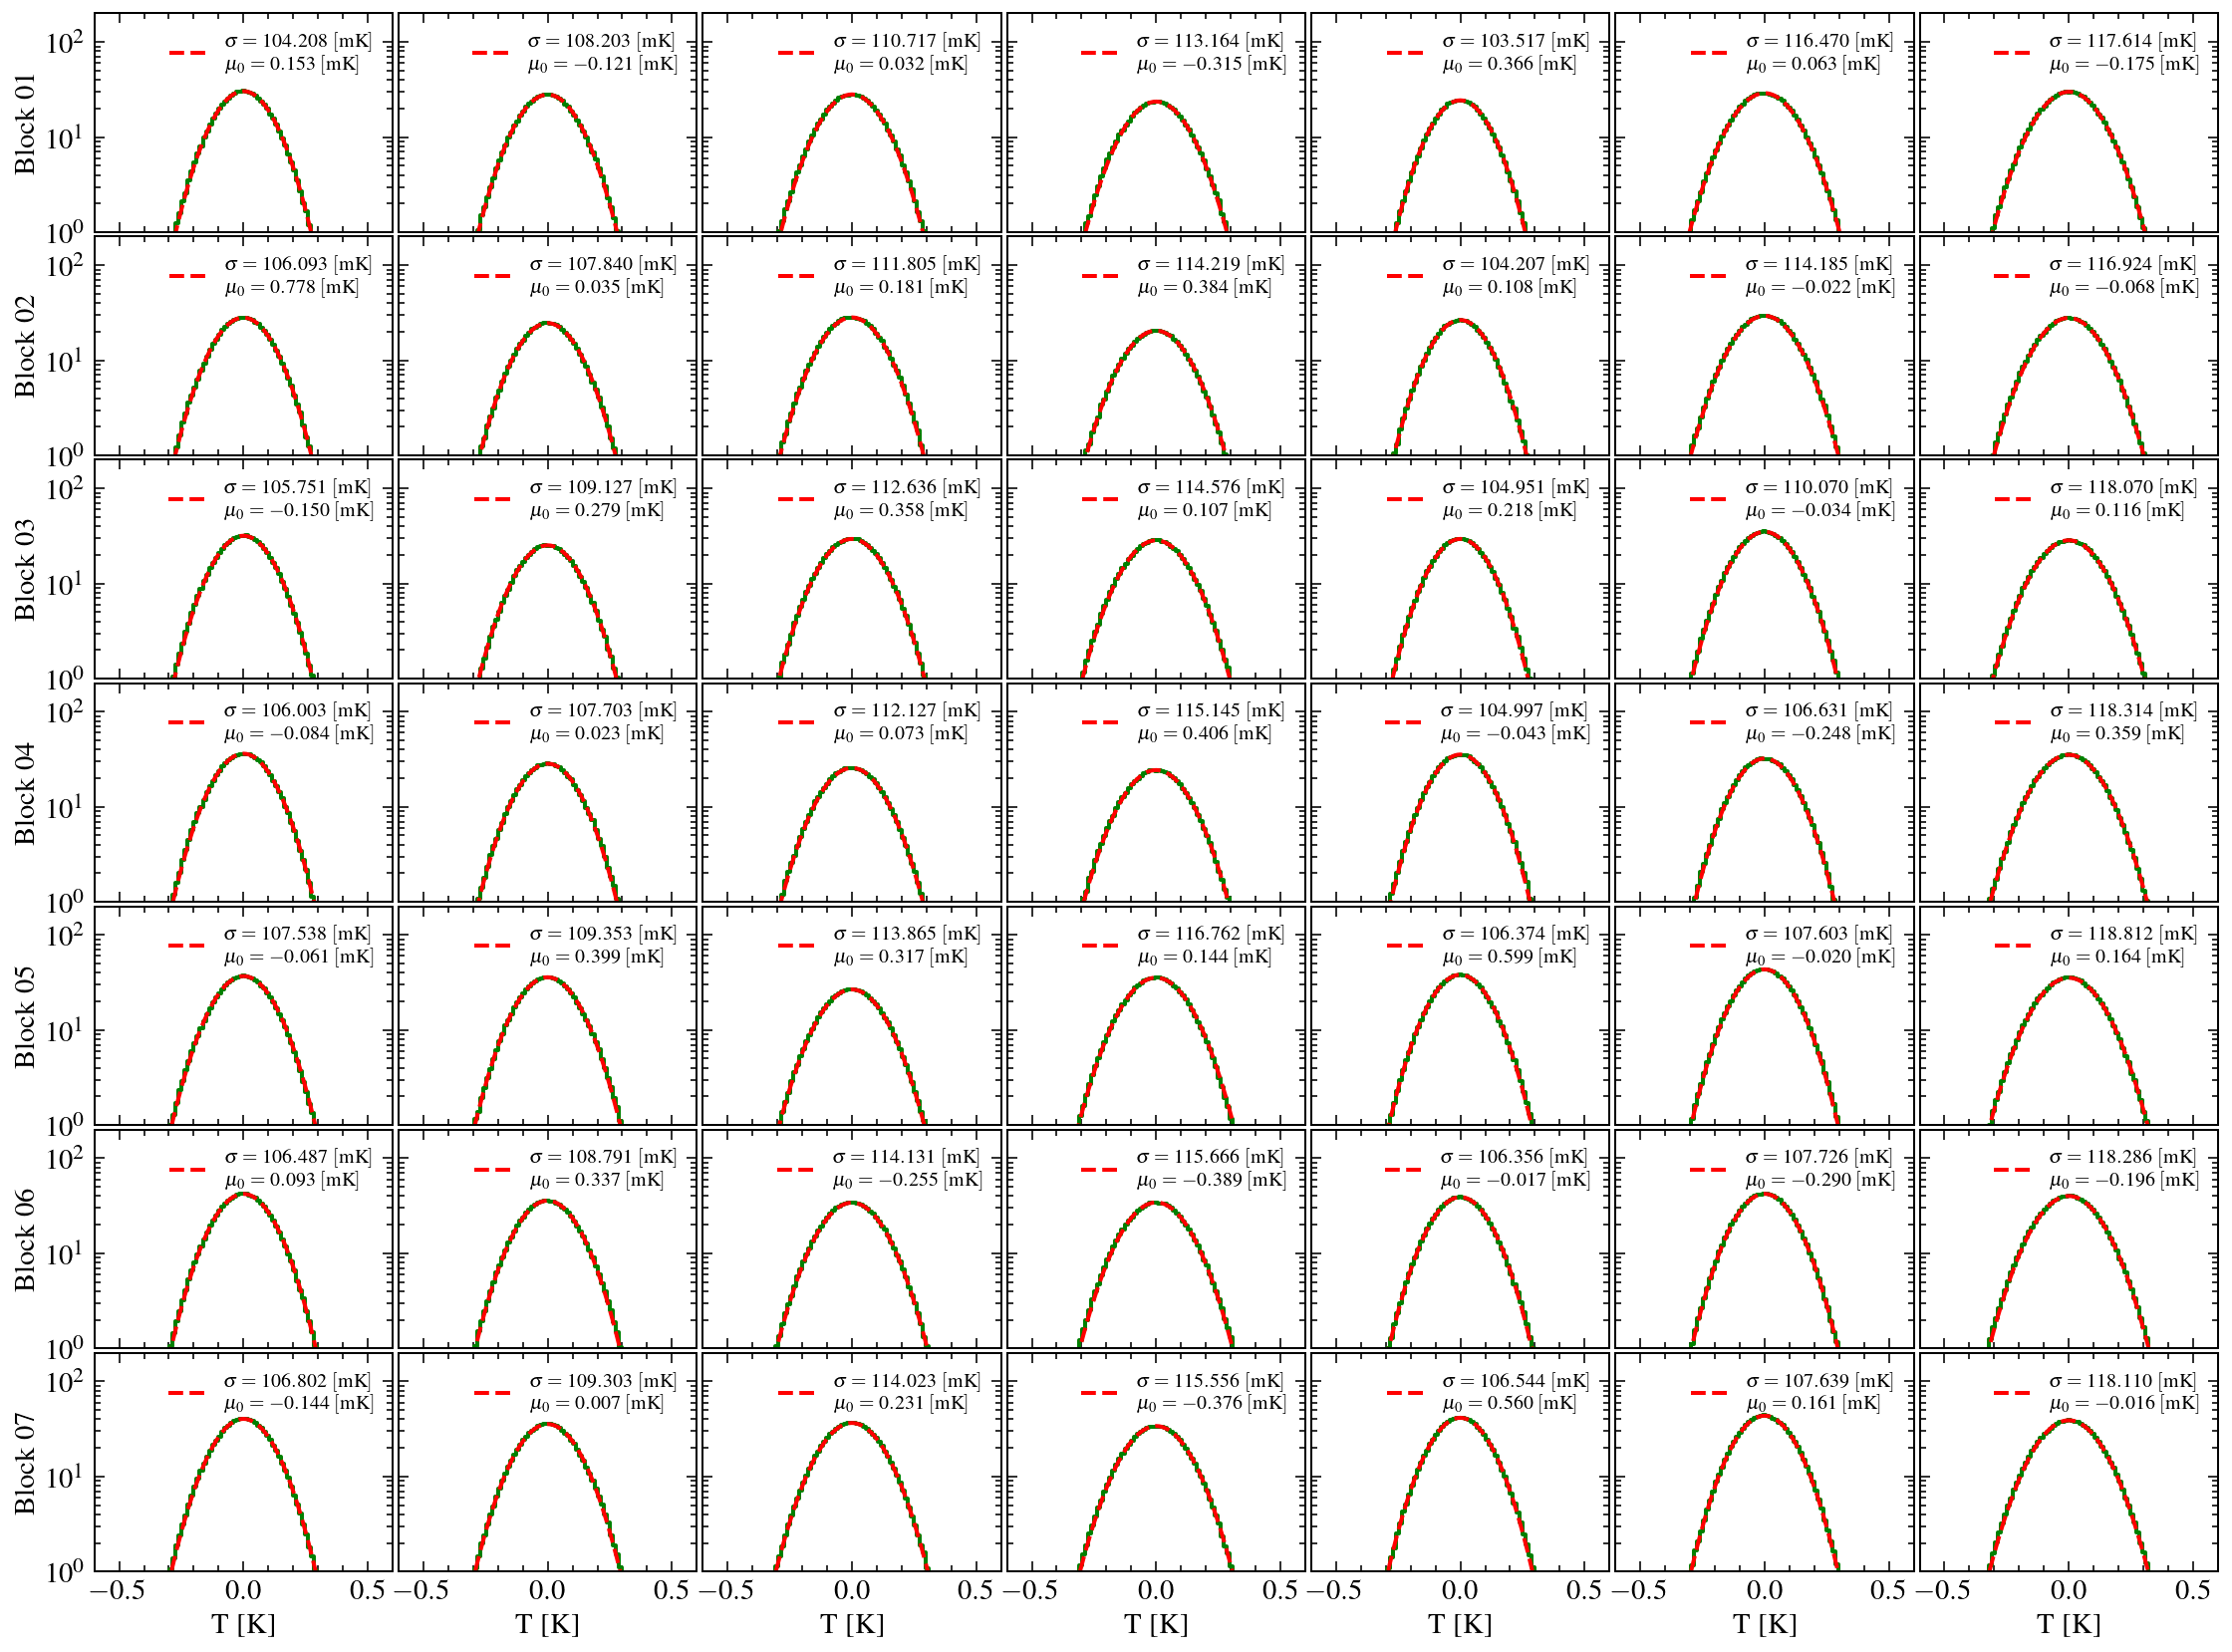

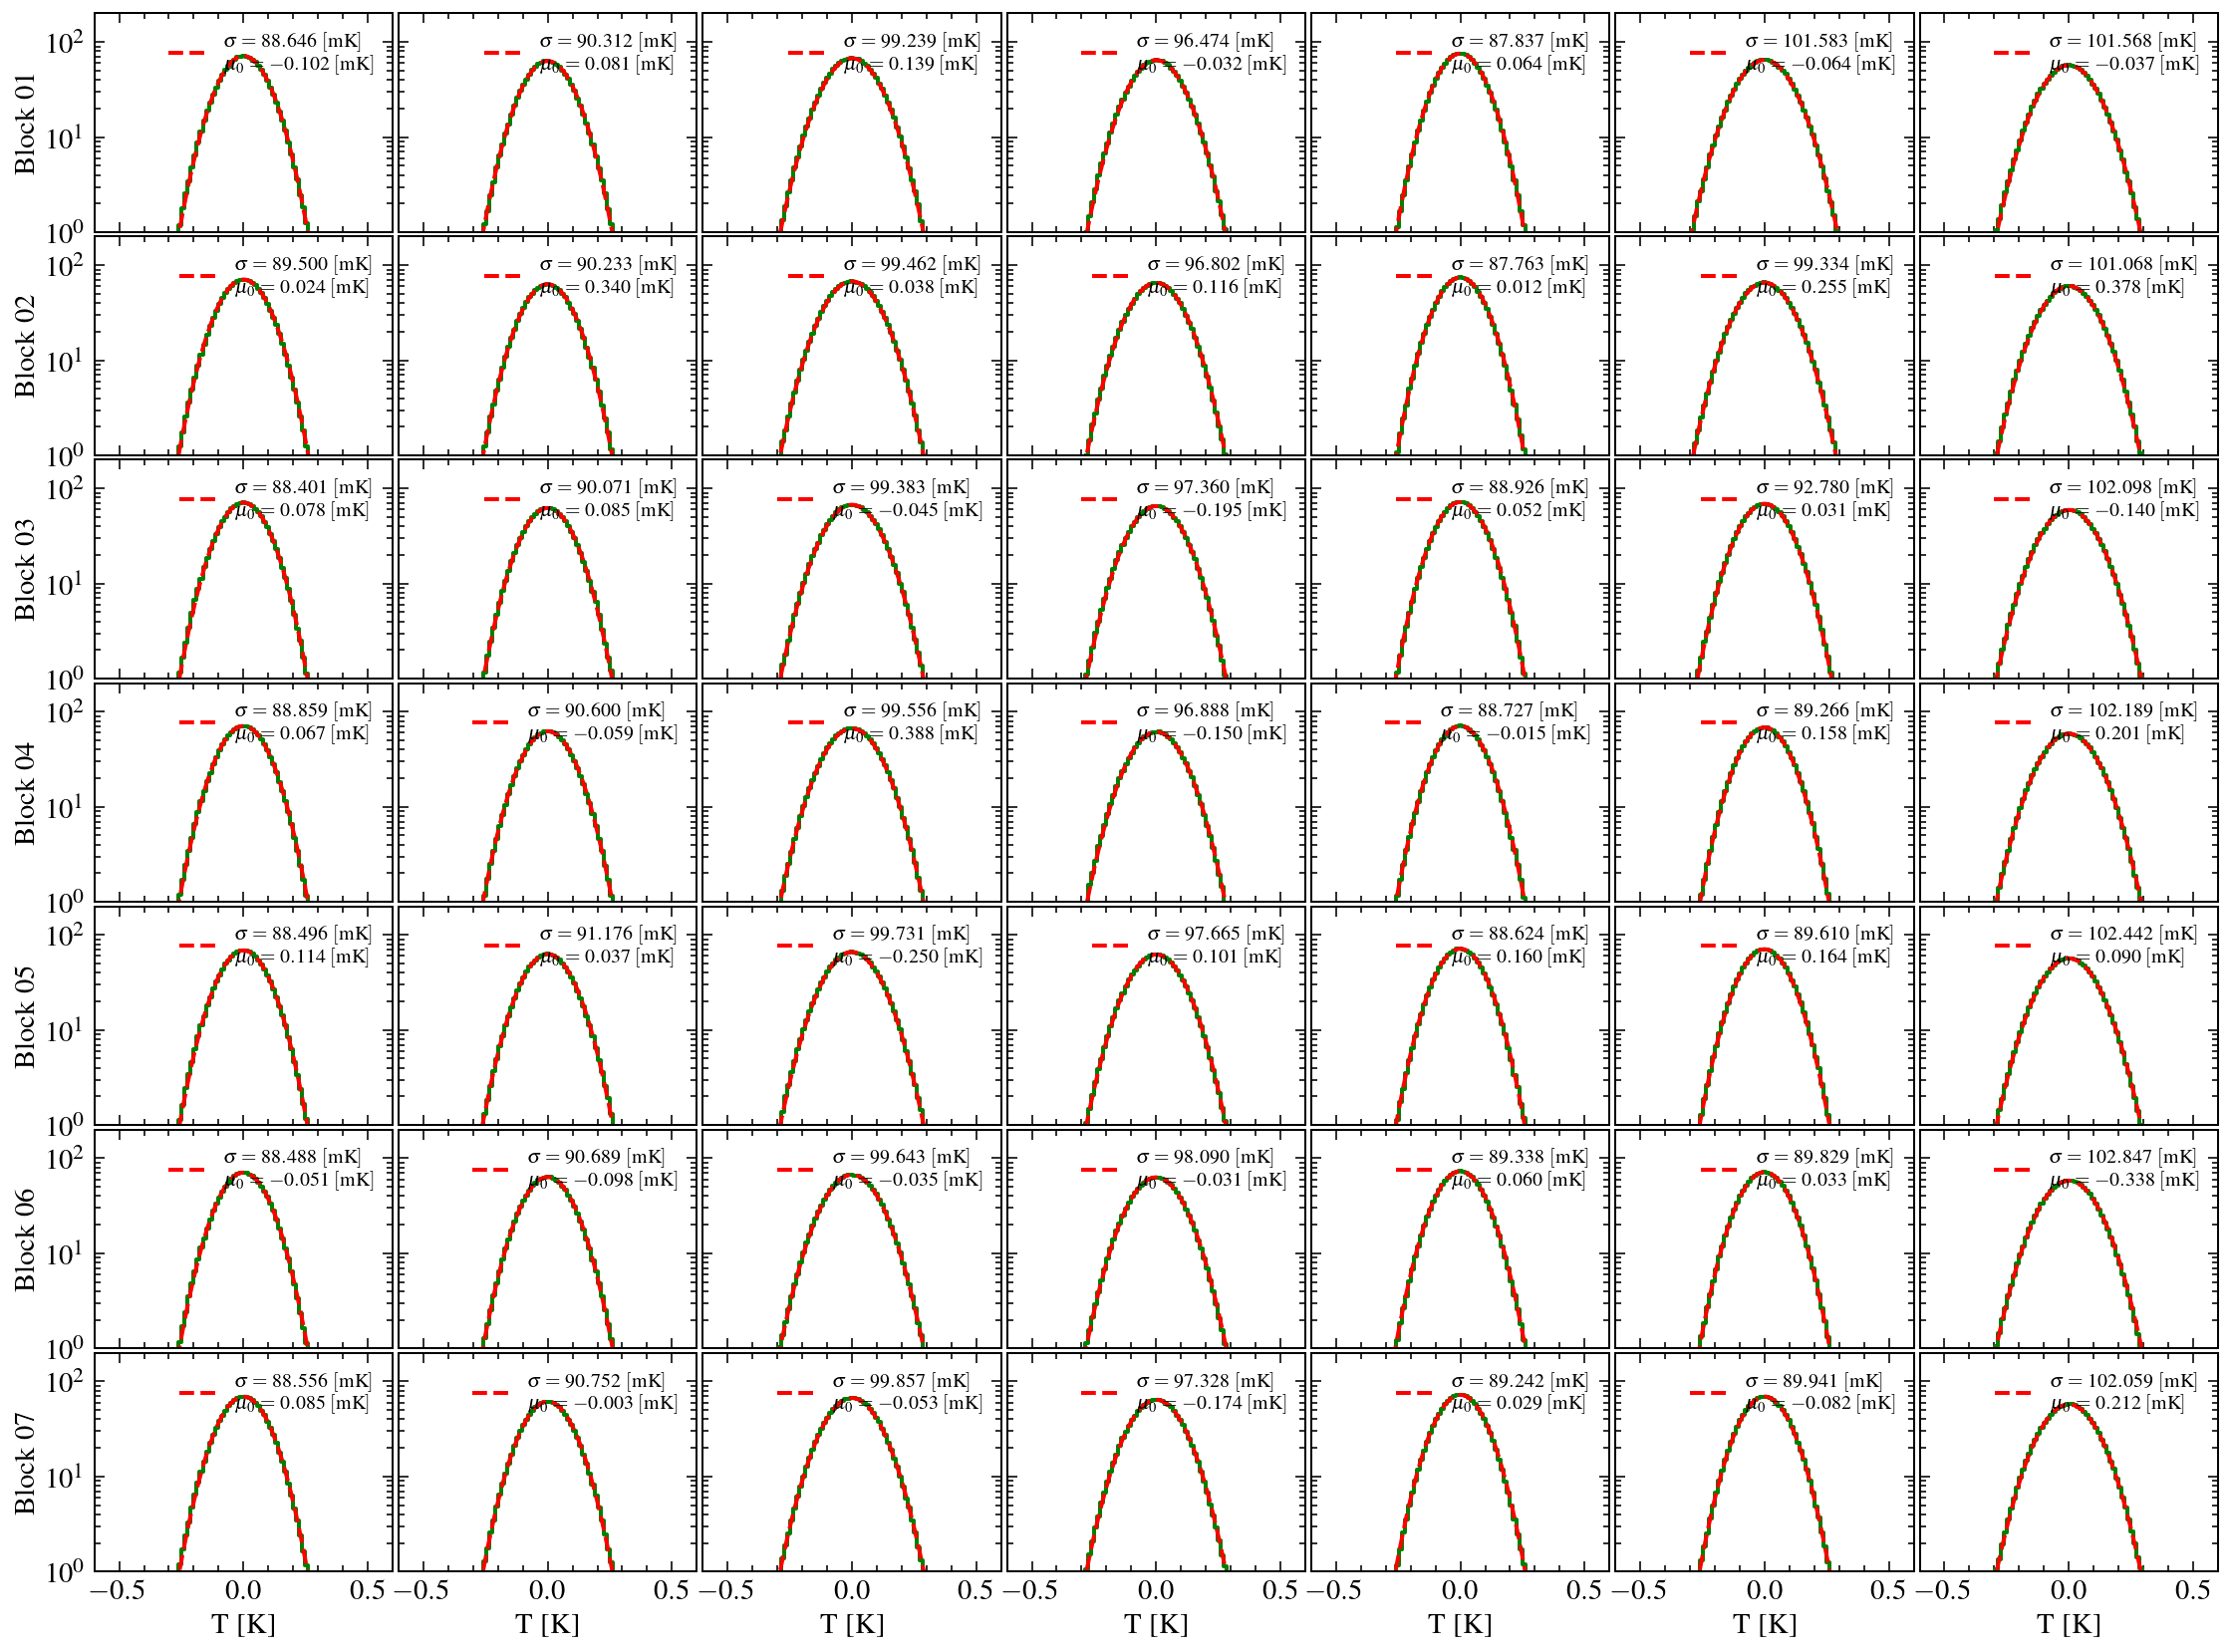

In [64]:
tsys.plot_tsys_tod_blocks(results_tod_l, bc, be, freq_diff, figsize = (16, 12), ylabel_list=ylabel_list)
tsys.plot_tsys_tod_blocks(results_tod_h, bc, be, freq_diff, figsize = (16, 12), ylabel_list=ylabel_list)

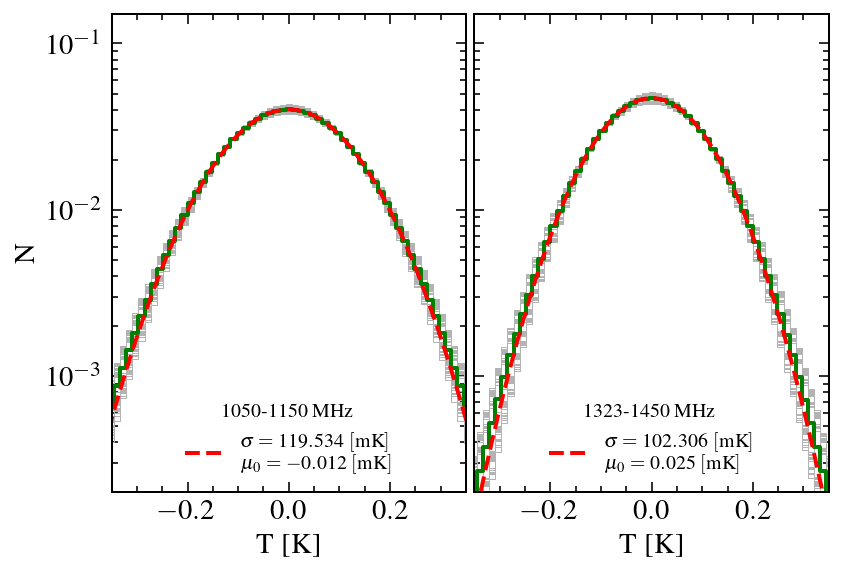

In [55]:
hist_l = np.sum(results_tod_l, axis=2)
hist_l.shape = (-1, bc.shape[0])

hist_h = np.sum(results_tod_h, axis=2)
hist_h.shape = (-1, bc.shape[0])
r_tod_l, r_tod_h = tsys.plot_rms_hist_low_and_high_band(hist_l, hist_h, bc, bc, be, be, 
                                     freq_diff='ABBA', xlim=(-0.35, 0.35), ylim=(2.e-4, 1.5e-1), 
                                     output_name='test.png')

### ABAB for each data block

In [34]:
tod_path = '/home/DATA/ycli/fanalysis/rmbsl_sumfeeds_CC/'

freq_diff = 'ABAB'

ylabel_list = ['Block 01', 'Block 02', 'Block 03', 'Block 04', 'Block 05', 'Block 06', 'Block 07']

tod_suffix_list = ['arcdrift%04d-%04d'%(i+1, i+1) for i in range(7)]

tod_cent_list = ['20210302/HIMGS_1100+2600', 
                 '20210309/HIMGS_1100+2610',
                 '20210314/HIMGS_1100+2610',
                 '20210313/HIMGS_1100+2621',
                 '20210305/HIMGS_1100+2632',
                 '20210306/HIMGS_1100+2643',
                 '20210307/HIMGS_1100+2654',
                 ]

title_list  = [ (x.replace('/', '\n')).replace('_', ' ') for x in tod_cent_list]

bad_beam_list = [[10,], 
                 [6, 10], [6, 10],
                 [9, 10], [],
                 [10, 17], [6,]
                ]

tod_freq = '1050-1150MHz'
results_tod_ABAB_l, bc, be = tsys.check_tsys_tod(tod_path, tod_suffix_list, tod_cent_list, tod_freq,
                                            freq_diff, freq_sel=slice(0, None))

tod_freq = '1250-1450MHz'
results_tod_ABAB_h, bc, be = tsys.check_tsys_tod(tod_path, tod_suffix_list, tod_cent_list, tod_freq,
                                            freq_diff, freq_sel=slice(2500, None))

Main:   0%|          | 0/49 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Main:   0%|          | 0/49 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

Beam:   0%|          | 0/19 [00:00<?, ?it/s]

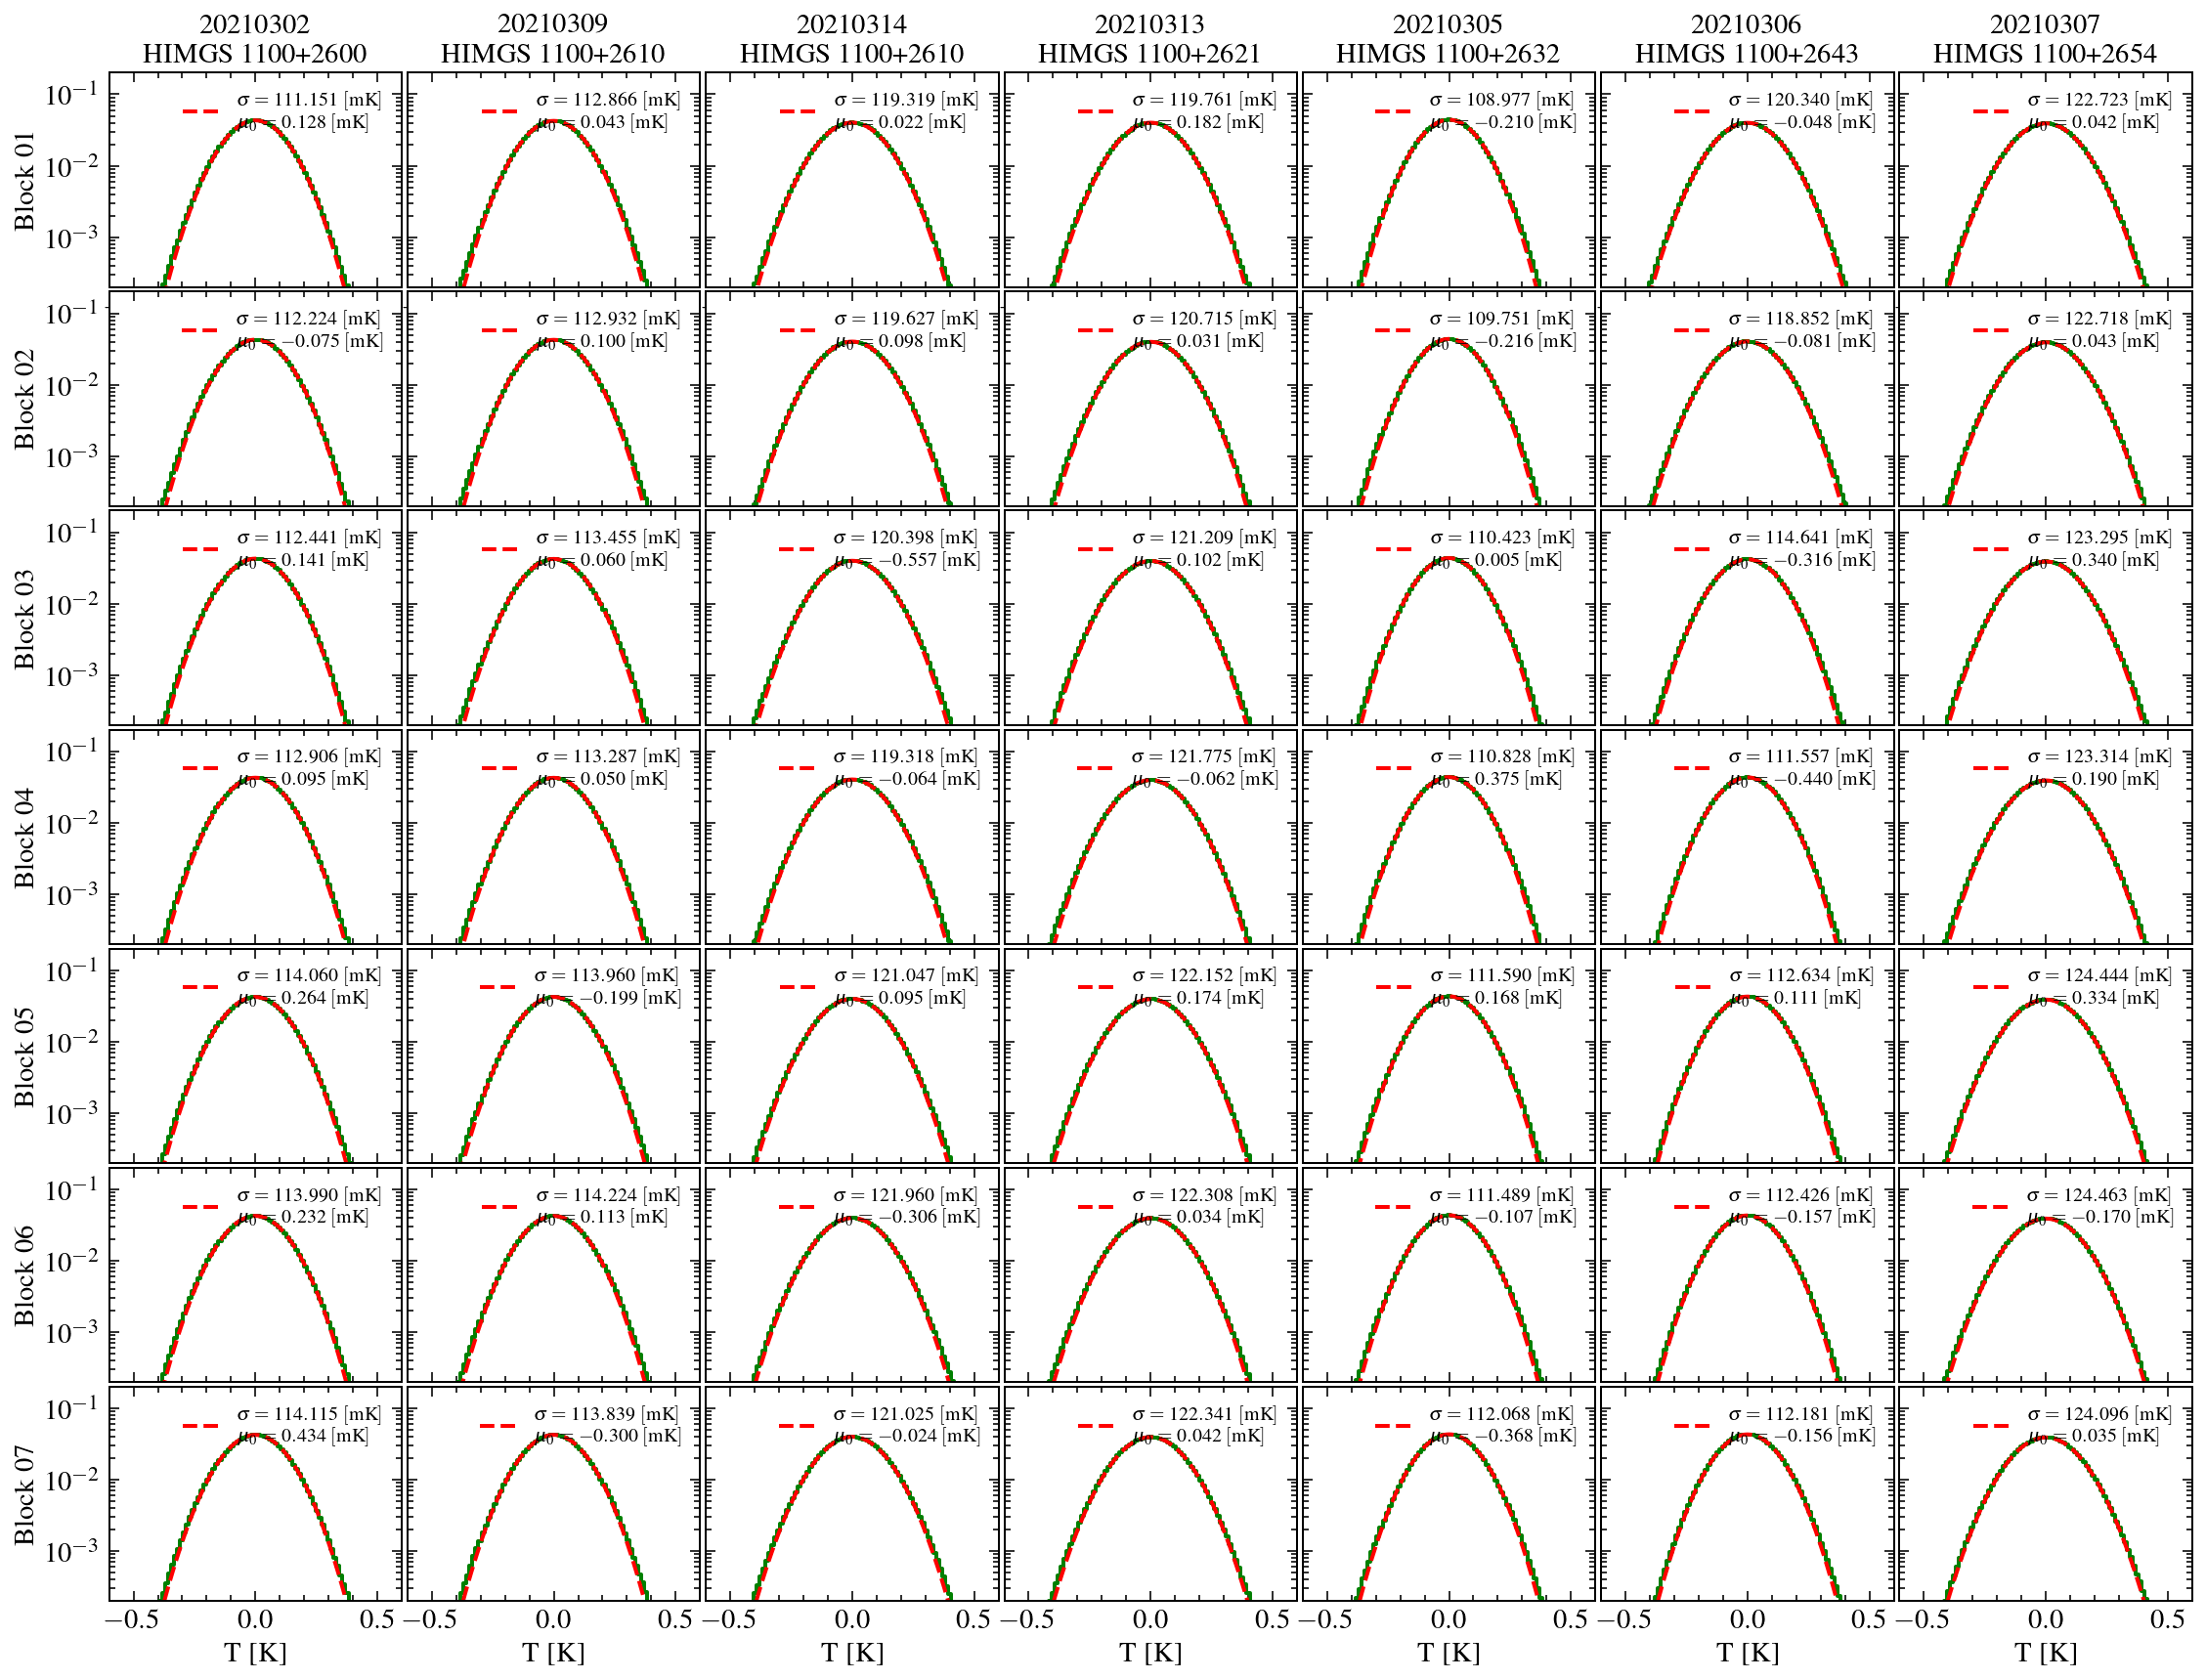

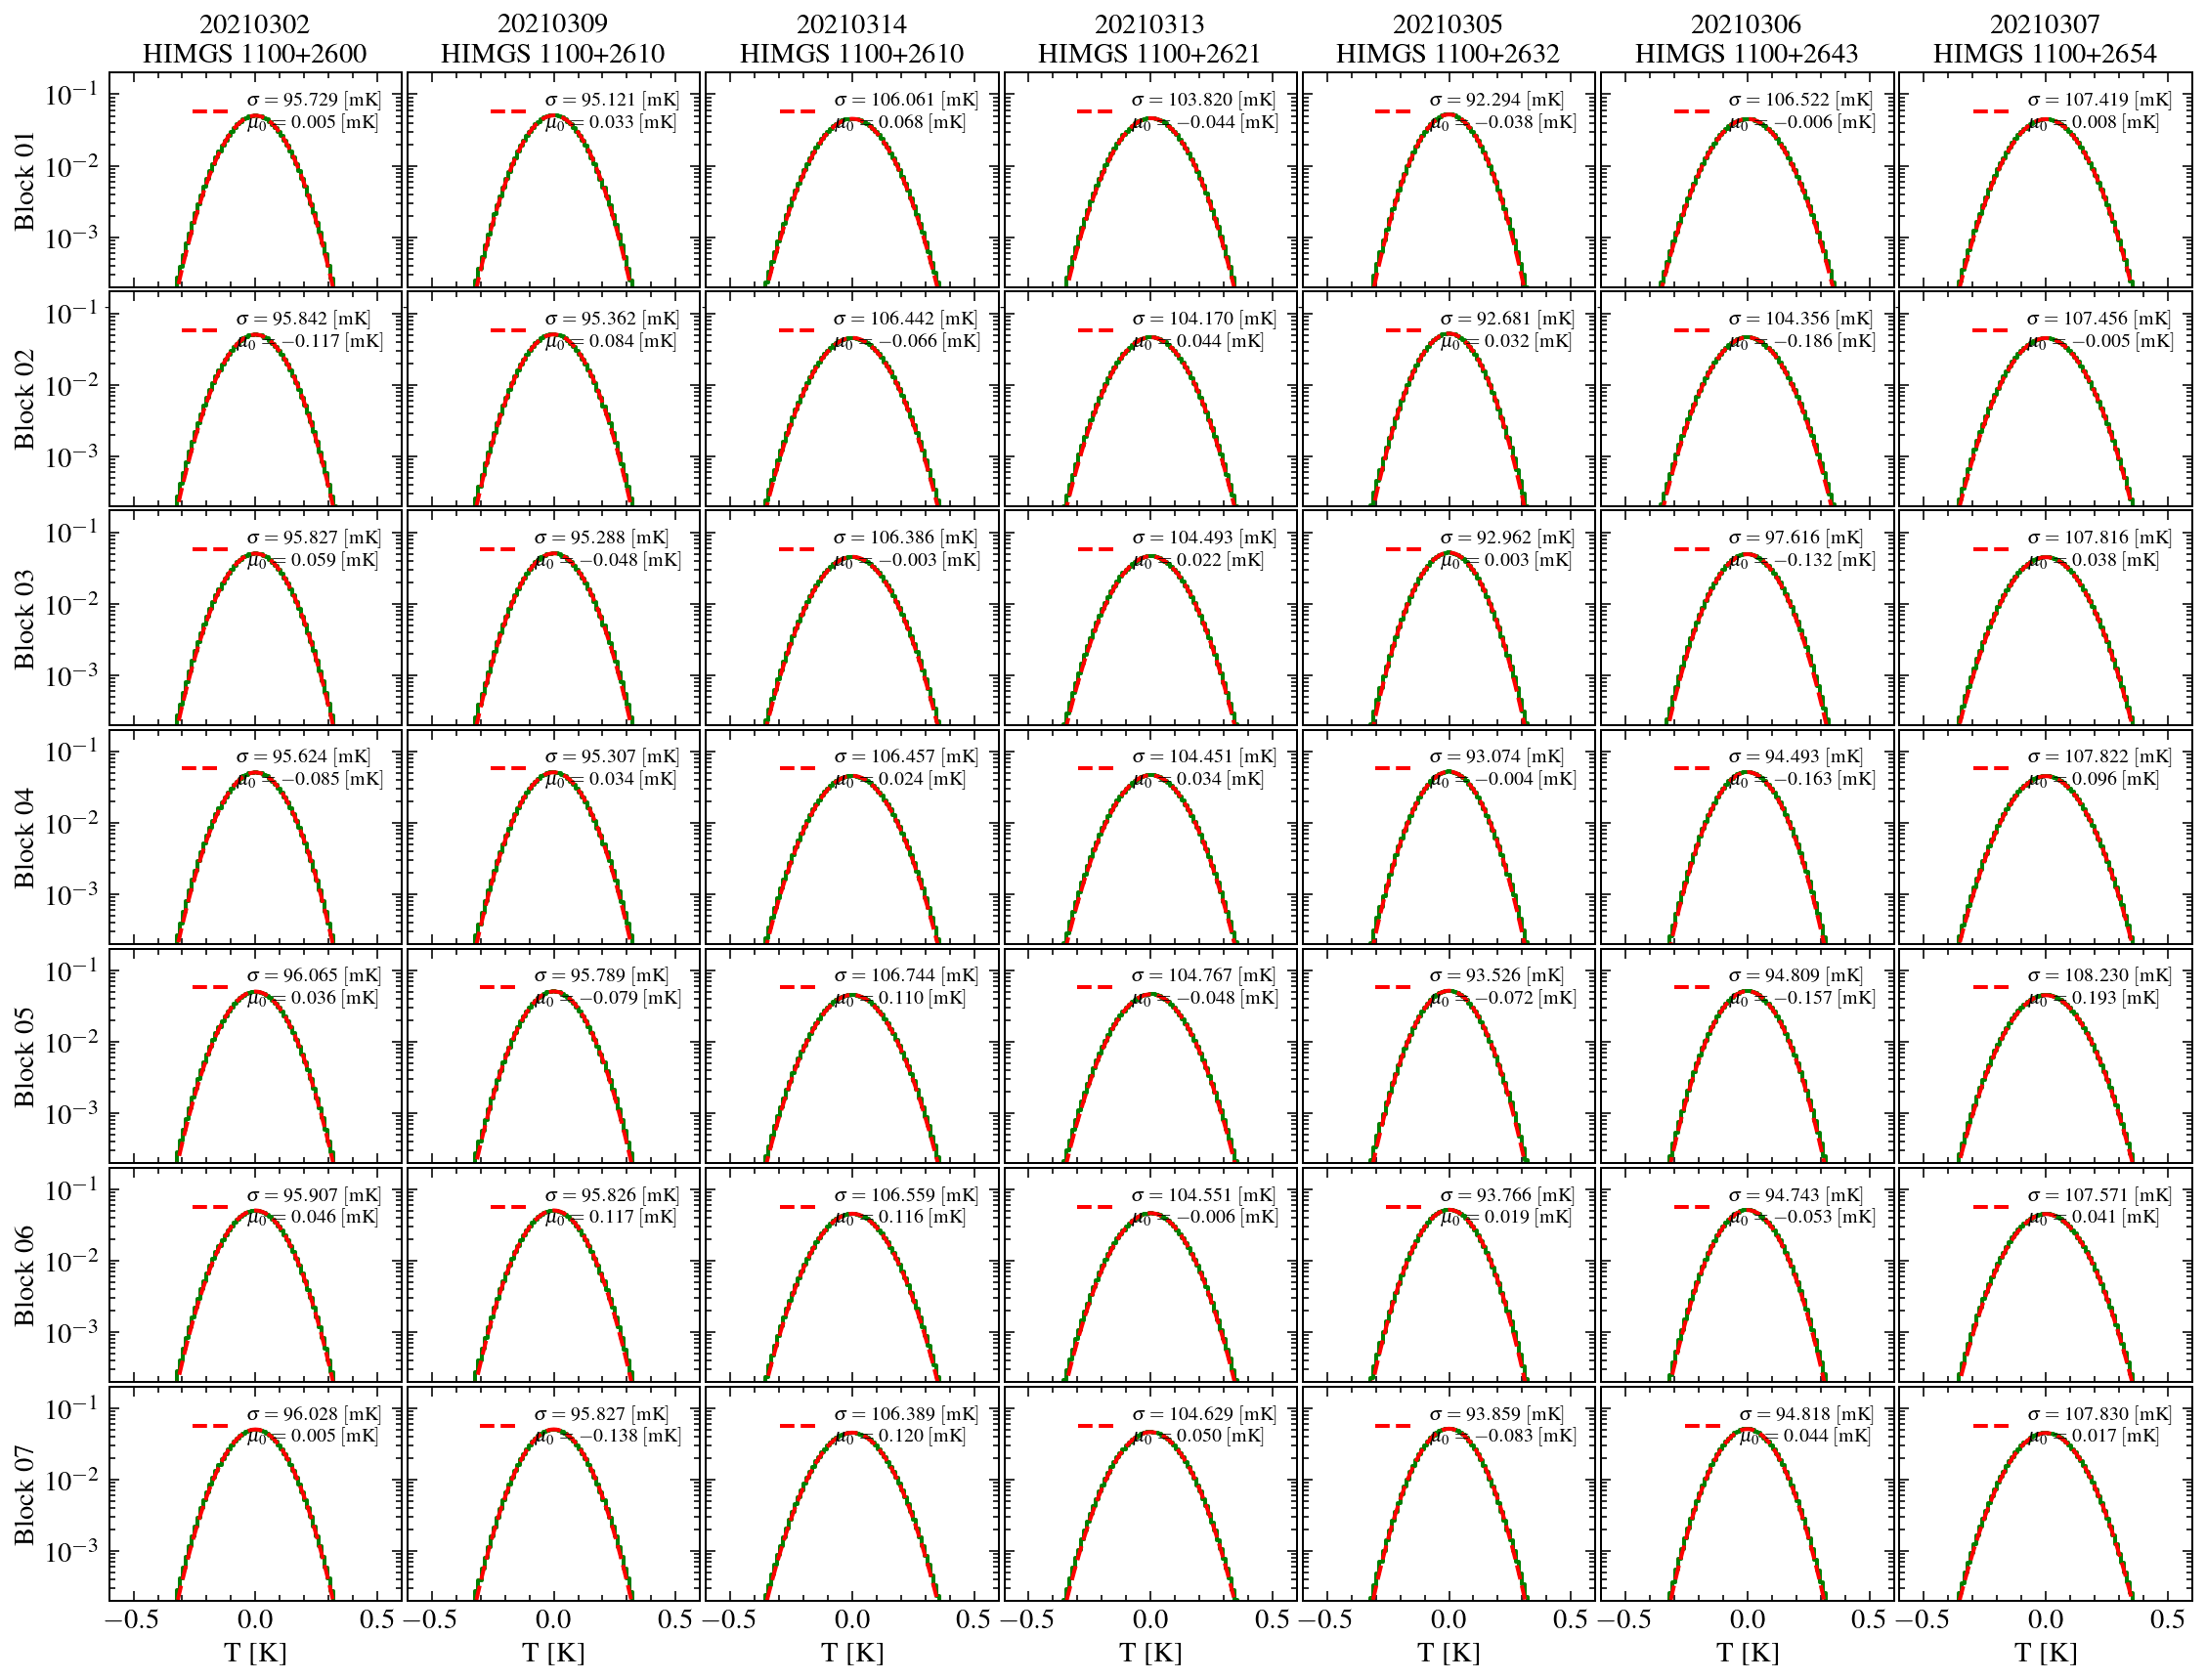

In [35]:
hist_l = results_tod_ABAB_l.copy()
hist_h = results_tod_ABAB_h.copy()

for i in range(hist_l.shape[1]):
    for j in bad_beam_list[i]:
        hist_l[:, i, j-1, ...] = 0
        hist_h[:, i, j-1, ...] = 0

hist_l = np.sum(hist_l, axis=2)[:, :, None, ...]
hist_h = np.sum(hist_h, axis=2)[:, :, None, ...]


tsys.plot_tsys_tod_blocks(hist_l, bc, be, freq_diff, figsize = (16, 12), 
                          ylabel_list=ylabel_list, title_list=title_list)
tsys.plot_tsys_tod_blocks(hist_h, bc, be, freq_diff, figsize = (16, 12), 
                          ylabel_list=ylabel_list, title_list=title_list)

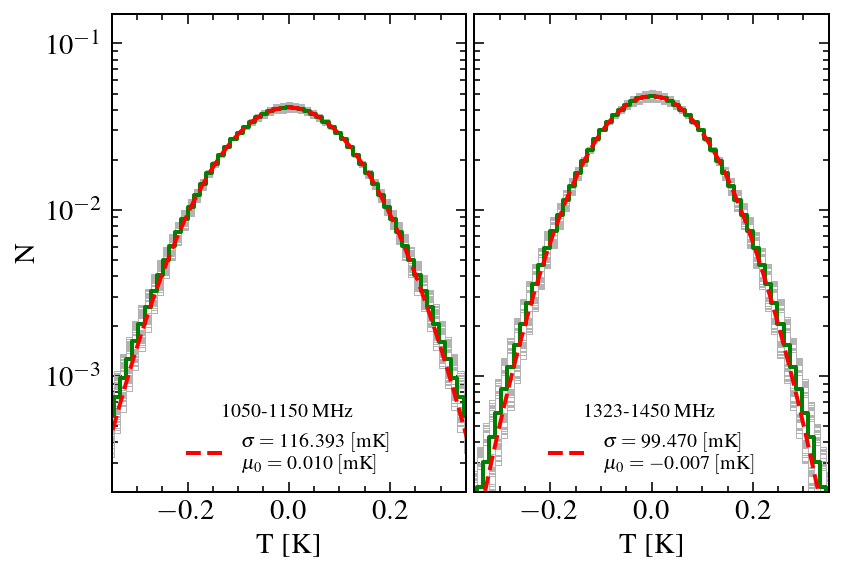

In [36]:
hist_l = results_tod_ABAB_l.copy()
hist_h = results_tod_ABAB_h.copy()

for i in range(hist_l.shape[1]):
    for j in bad_beam_list[i]:
        hist_l[:, i, j-1, ...] = 0
        hist_h[:, i, j-1, ...] = 0


hist_l = np.sum(hist_l, axis=2)
hist_l.shape = (-1, bc.shape[0])

hist_h = np.sum(hist_h, axis=2)
hist_h.shape = (-1, bc.shape[0])
r_tod_l, r_tod_h = tsys.plot_rms_hist_low_and_high_band(hist_l, hist_h, bc, bc, be, be, 
                                     freq_diff='ABAB', xlim=(-0.35, 0.35), ylim=(2.e-4, 1.5e-1), 
                                     output_name='plot/rms_tod.png')

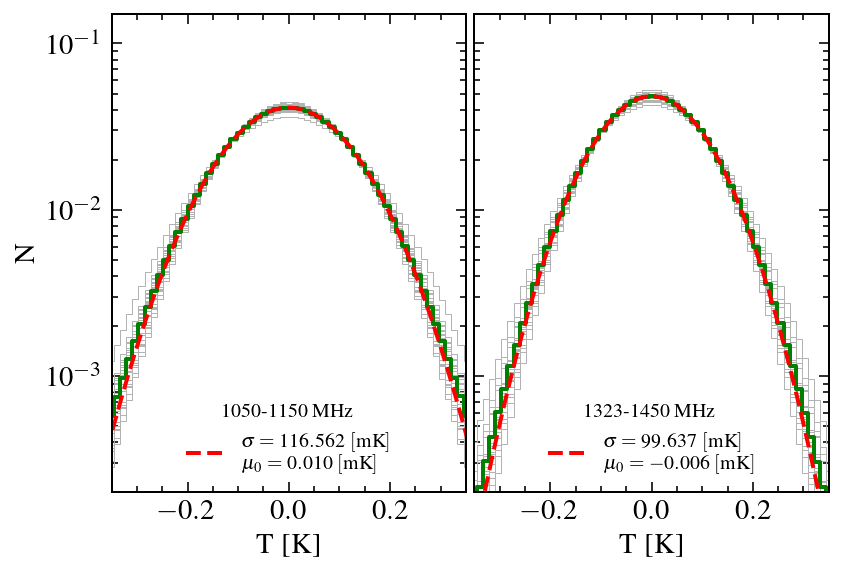

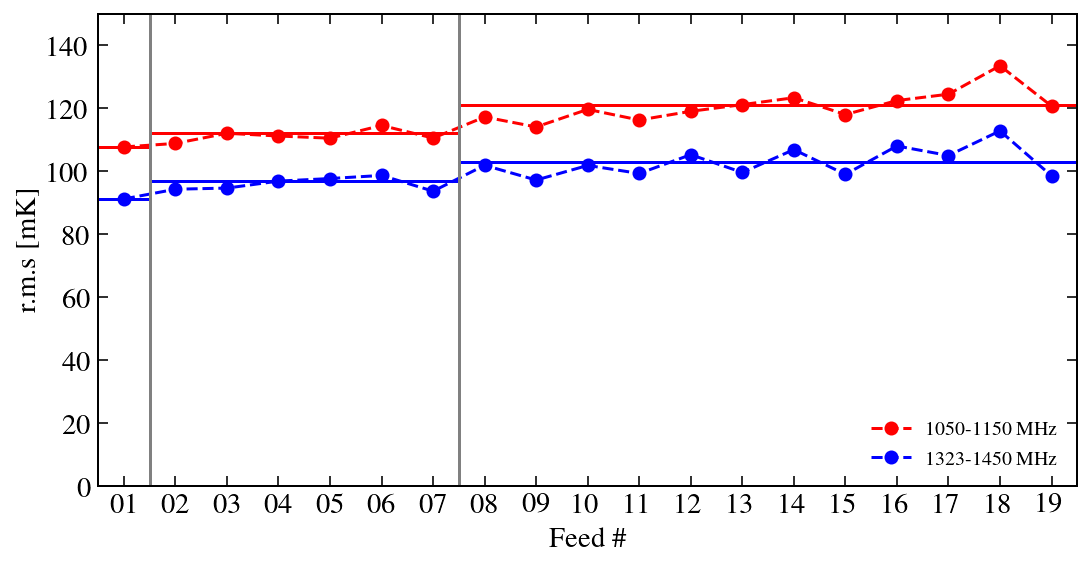

In [76]:
hist_l_beam = results_tod_ABAB_l.copy()
hist_h_beam = results_tod_ABAB_h.copy()


hist_l_beam = np.sum(hist_l_beam, axis=(0, 1))
#hist_l.shape = (-1, bc.shape[0])

hist_h_beam = np.sum(hist_h_beam, axis=(0, 1))
hist_h.shape = (-1, bc.shape[0])
r_tod_l_beam, r_tod_h_beam = tsys.plot_rms_hist_low_and_high_band(hist_l_beam, hist_h_beam, bc, bc, be, be, 
                                     freq_diff='ABAB', xlim=(-0.35, 0.35), ylim=(2.e-4, 1.5e-1), 
                                     output_name='plot/rms_tod_beam.png')


tsys.plot_rms_beam(r_tod_l_beam[:, 0]*1.e3, r_tod_h_beam[:, 0]*1.e3)

In [38]:
Tsys_h =  99.5 * (2 * 28e3 * 1)**0.5 * 1.e-3
Tsys_l = 116.4 * (2 * 28e3 * 1)**0.5 * 1.e-3
print(Tsys_h, Tsys_l)

23.545997536736472 27.545267470111813


In [3]:
(99.5 - 84.5) / 84.5

0.17751479289940827

In [ ]:
tod_path = '/home/DATA/ycli/fanalysis/rmbsl_sumfeeds_CC/'

freq_diff = 'ABAB'

ylabel_list = ['Block 01', 'Block 02', 'Block 03', 'Block 04', 'Block 05', 'Block 06', 'Block 07']
tod_suffix_list = ['arcdrift%04d-%04d'%(i+1, i+1) for i in range(7)]

tod_cent_list = ['20210302/HIMGS_1100+2600', 
                 '20210309/HIMGS_1100+2610',
                 '20210314/HIMGS_1100+2610',
                 '20210313/HIMGS_1100+2621',
                 '20210305/HIMGS_1100+2632',
                 '20210306/HIMGS_1100+2643',
                 '20210307/HIMGS_1100+2654',
                 ]

bad_beam_list = [[10,], 
                 [6, 10], [6, 10],
                 [9, 10], [],
                 [10, 17], [6,]
                ]

tod_freq = '1050-1150MHz'
results_tod_ABAB_l, bc, be = tsys.check_tsys_tod(tod_path, tod_suffix_list, tod_cent_list, tod_freq,
                                            freq_diff, freq_sel=slice(0, None), per_freq=True)

tod_freq = '1250-1450MHz'
results_tod_ABAB_h, bc, be = tsys.check_tsys_tod(tod_path, tod_suffix_list, tod_cent_list, tod_freq,
                                            freq_diff, freq_sel=slice(2500, None), per_freq=True)

23.42767594107448

## **Check Tsys using Map**

### check hit per freq

In [54]:
tod_path = '/home/DATA/ycli/fanalysis/rmbsl_sumfeeds_CC/'
ylabel_list = ['Block 01', 'Block 02', 'Block 03', 'Block 04', 'Block 05', 'Block 06', 'Block 07']
tod_suffix_list = ['arcdrift%04d-%04d'%(i+1, i+1) for i in range(7)]

tod_cent_list = ['20210302/HIMGS_1100+2600', 
                 '20210309/HIMGS_1100+2610',
                 '20210314/HIMGS_1100+2610',
                 '20210313/HIMGS_1100+2621',
                 '20210305/HIMGS_1100+2632',
                 '20210306/HIMGS_1100+2643',
                 '20210307/HIMGS_1100+2654',
                 ]
tod_freq = '1050-1150MHz'
freq_sel = slice(0, None)
hit_per_freq_l = []
for jj, ii, m, mask in tsys.iter_tod_files(tod_path, tod_suffix_list, tod_cent_list, tod_freq, freq_sel):
    #print(mask.shape)
    hit_per_freq_l.append( np.sum( (~mask).astype('int'), axis=(0, 2) ) )
    
tod_freq = '1250-1450MHz'
freq_sel = slice(2500, None)
hit_per_freq_h = []
for jj, ii, m, mask in tsys.iter_tod_files(tod_path, tod_suffix_list, tod_cent_list, tod_freq, freq_sel):
    #print(mask.shape)
    hit_per_freq_h.append( np.sum( (~mask).astype('int'), axis=(0, 2) ) )

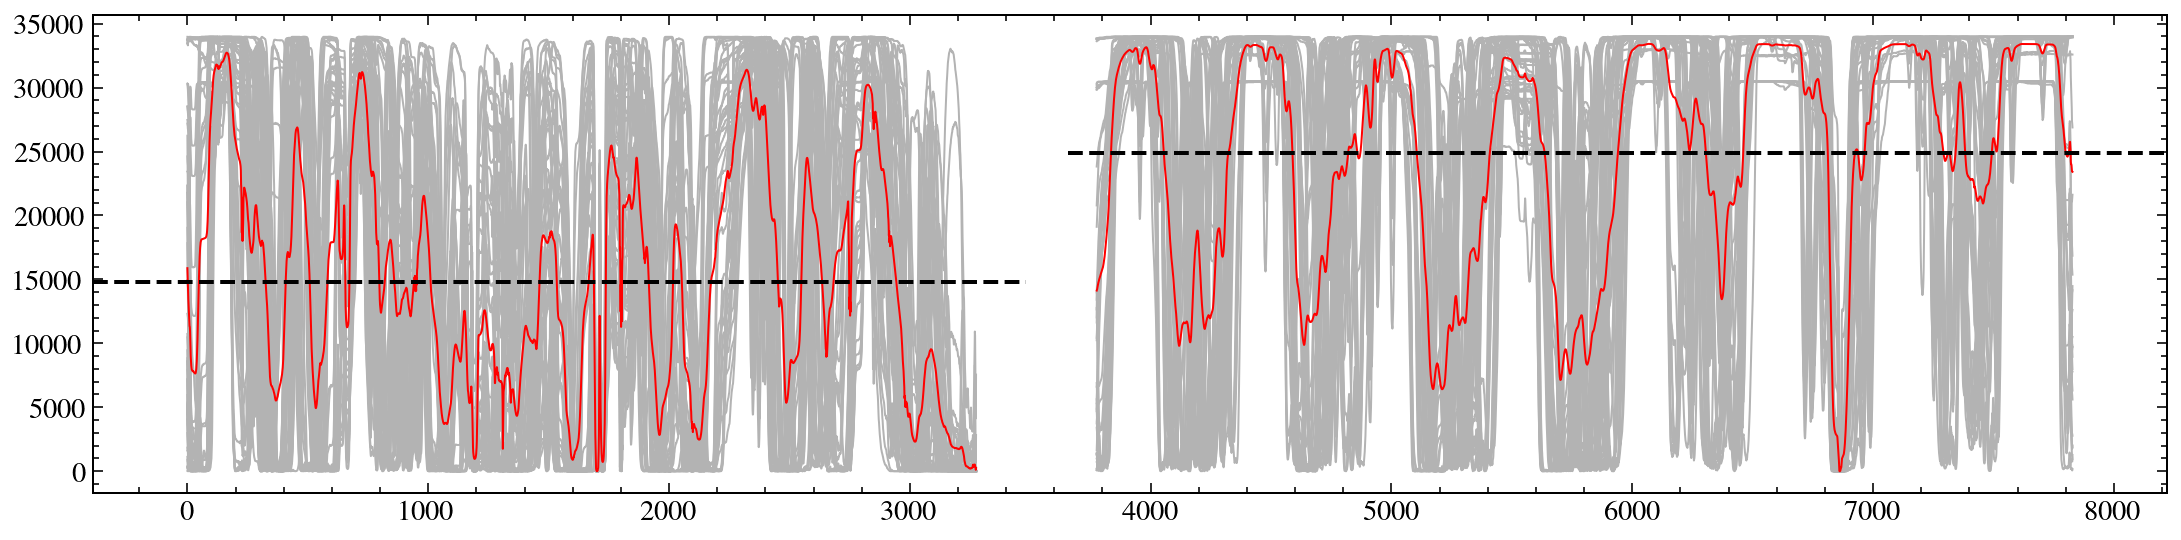

In [55]:
hit_per_freq_l = np.array(hit_per_freq_l)
hit_per_freq_h = np.array(hit_per_freq_h)

fig = plt.figure(figsize=(18, 4))
ax  = fig.add_axes([0.1, 0.07, 0.8, 0.83])

xx_l = np.arange(hit_per_freq_l.shape[1])
xx_h = np.arange(hit_per_freq_h.shape[1]) + hit_per_freq_l.shape[1] + 500

for ii in range(49):
    ax.plot(xx_l, hit_per_freq_l[ii], '0.7', lw=1)
    ax.plot(xx_h, hit_per_freq_h[ii], '0.7', lw=1)

hit_per_freq_l_mean = np.mean(hit_per_freq_l, axis=0)
hit_per_freq_h_mean = np.mean(hit_per_freq_h, axis=0)

ax.plot(xx_l, hit_per_freq_l_mean, 'r', lw=1)
ax.plot(xx_h, hit_per_freq_h_mean, 'r', lw=1)

threshold_l = np.mean(hit_per_freq_l_mean) * 1.0
threshold_h = np.mean(hit_per_freq_h_mean) * 1.0

ax.axhline(threshold_l, 0.00, 0.45, c='k', ls='--', lw=2)
ax.axhline(threshold_h, 0.47, 1.00, c='k', ls='--', lw=2)

freq_mask_l = hit_per_freq_l_mean < threshold_l
freq_mask_h = hit_per_freq_h_mean < threshold_h

### ABBA for the combined map

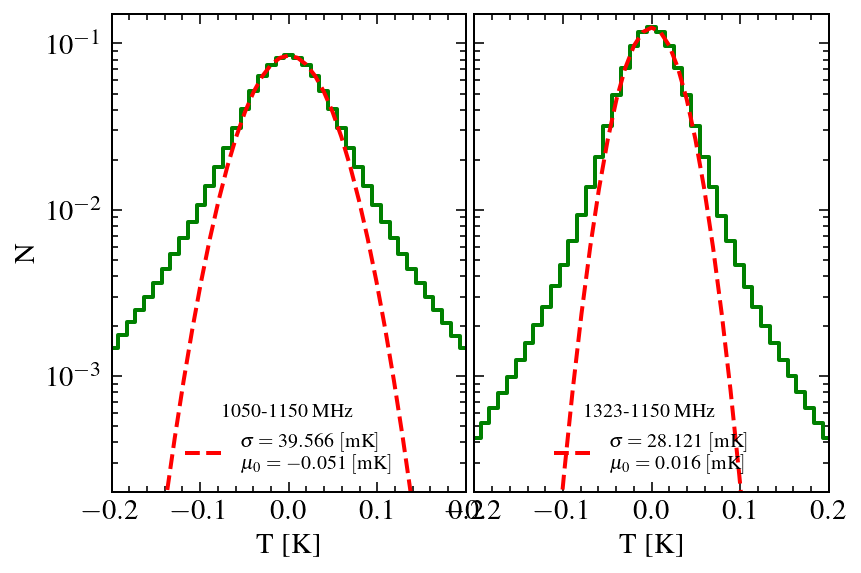

In [43]:
freq_mask_l = None
freq_mask_h = None

map_path = '/home/DATA/ycli/fanalysis/map_df28k_2021/'
map_name = 'cm_Combined_1050-1150MHz.h5'

freq_diff = 'ABBA'
results_map_ABBA_l, bc_map, be_map = tsys.check_tsys_map(map_path, [map_name, ], freq_diff, 
                                                         freq_sel=slice(0, None),
                                                         freq_mask=freq_mask_l) 

map_path = '/home/DATA/ycli/fanalysis/map_df28k_2021/'
map_name = 'cm_Combined_1250-1450MHz.h5'

freq_diff = 'ABBA'
results_map_ABBA_h, bc_map, be_map = tsys.check_tsys_map(map_path, [map_name, ], freq_diff, 
                                                         freq_sel=slice(2500, None),
                                                         freq_mask=freq_mask_h)

r_map_l, r_map_h = tsys.plot_rms_hist_low_and_high_band(results_map_ABBA_l, results_map_ABBA_h, 
                                                        bc_map, bc_map, be_map, be_map, 
                                                        freq_diff=freq_diff, xlim=(-0.19, 0.19), 
                                                        ylim=(2.e-4, 1.5e-1), output_name='test.png')

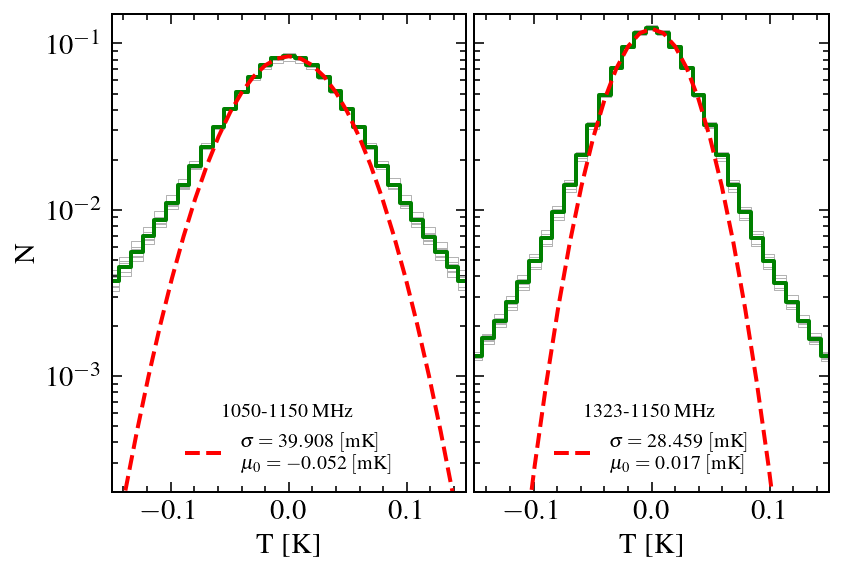

In [50]:
freq_mask_l = None
freq_mask_h = None

map_path = '/home/DATA/ycli/fanalysis/map_df28k_2021/'
map_name_list = ['cm_%02d_Combined_1050-1150MHz_vis.h5'%ii for ii in range(7)]

freq_diff = 'ABBA'
results_map_ABBA_l, bc_map, be_map = tsys.check_tsys_map(map_path, map_name_list, freq_diff, 
                                                         freq_sel=slice(0, None),
                                                         freq_mask=freq_mask_l) 

map_path = '/home/DATA/ycli/fanalysis/map_df28k_2021/'
map_name_list = ['cm_%02d_Combined_1250-1450MHz_vis.h5'%ii for ii in range(7)]

freq_diff = 'ABBA'
results_map_ABBA_h, bc_map, be_map = tsys.check_tsys_map(map_path, map_name_list, freq_diff, 
                                                         freq_sel=slice(2500, None),
                                                         freq_mask=freq_mask_h)

r_map_l, r_map_h = tsys.plot_rms_hist_low_and_high_band(results_map_ABBA_l, results_map_ABBA_h, 
                                                        bc_map, bc_map, be_map, be_map, 
                                                        freq_diff=freq_diff, xlim=(-0.19, 0.19), 
                                                        ylim=(2.e-4, 1.5e-1), output_name='test.png')

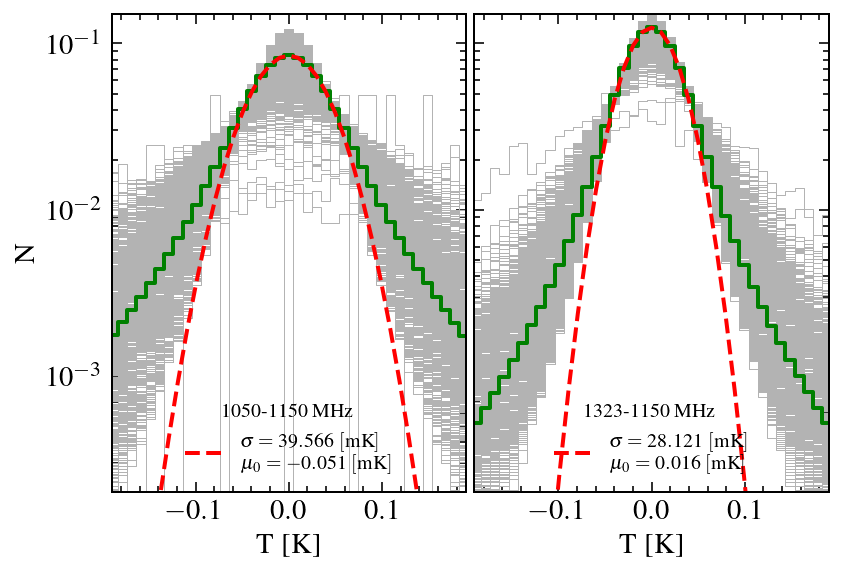

In [51]:
freq_mask_l = None
freq_mask_h = None

map_path = '/home/DATA/ycli/fanalysis/map_df28k_2021/'
map_name = 'cm_Combined_1050-1150MHz.h5'

freq_diff = 'ABBA'
results_map_ABBA_l, bc_map, be_map = tsys.check_tsys_map(map_path, [map_name, ], freq_diff, 
                                                         freq_sel=slice(0, None),
                                                         freq_mask=freq_mask_l, per_freq=True) 

map_path = '/home/DATA/ycli/fanalysis/map_df28k_2021/'
map_name = 'cm_Combined_1250-1450MHz.h5'

freq_diff = 'ABBA'
results_map_ABBA_h, bc_map, be_map = tsys.check_tsys_map(map_path, [map_name, ], freq_diff, 
                                                         freq_sel=slice(2500, None),
                                                         freq_mask=freq_mask_h, per_freq=True)

r_map_l, r_map_h = tsys.plot_rms_hist_low_and_high_band(results_map_ABBA_l[0], results_map_ABBA_h[0], 
                                                        bc_map, bc_map, be_map, be_map, 
                                                        freq_diff=freq_diff, xlim=(-0.19, 0.19), 
                                                        ylim=(2.e-4, 1.5e-1), output_name='test.png')

### ABBA for the each data blocks

In [40]:
map_path = '/home/DATA/ycli/fanalysis/map_df28k_2021/'
freq_diff = 'ABBA'

obs_list = ['HIMGS_1100+2600_20210302', 
            'HIMGS_1100+2610_20210309',
            'HIMGS_1100+2610_20210314',
            'HIMGS_1100+2621_20210313',
            'HIMGS_1100+2632_20210305',
            'HIMGS_1100+2643_20210306',
            'HIMGS_1100+2654_20210307',
            ]

freq_band = '_1050-1150MHz'
map_name_list = []
for i in range(7):
    for obs in obs_list:
        map_name_list.append('cm_%02d_%s%s_vis.h5'%(i, obs, freq_band))
results_map_ABBA_l, bc_map, be_map = tsys.check_tsys_map(map_path, map_name_list, freq_diff, 
                                                         freq_sel=slice(0, None))

freq_band = '_1250-1450MHz'
map_name_list = []
for i in range(7):
    for obs in obs_list:
        map_name_list.append('cm_%02d_%s%s_vis.h5'%(i, obs, freq_band))
results_map_ABBA_h, bc_map, be_map = tsys.check_tsys_map(map_path, map_name_list, freq_diff, 
                                                         freq_sel=slice(2500, None))

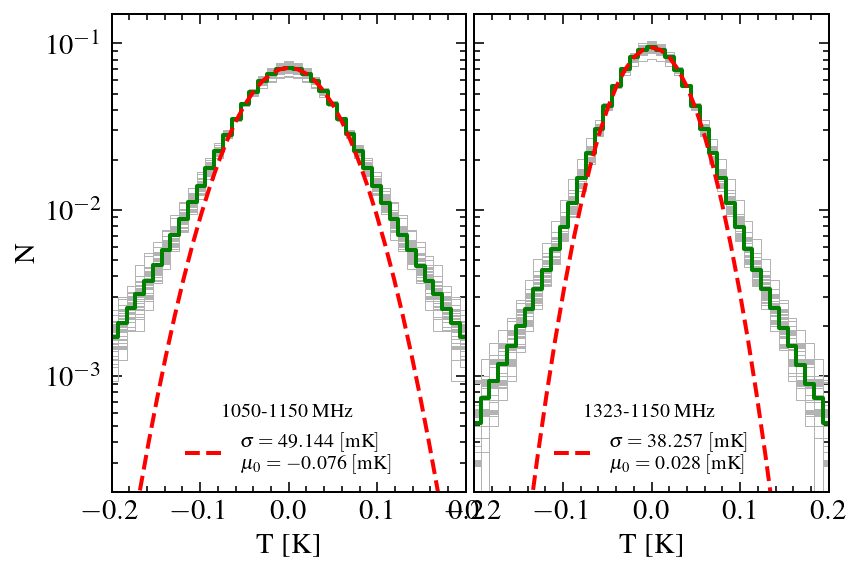

In [41]:
r_map_l, r_map_h = tsys.plot_rms_hist_low_and_high_band(results_map_ABBA_l, results_map_ABBA_h, 
                                                        bc_map, bc_map, be_map, be_map, 
                                                        freq_diff=freq_diff, xlim=(-0.2, 0.2), 
                                                        ylim=(2.e-4, 1.5e-1), output_name='test.png')

### ABAB for the combined map

Main:   0%|          | 0/1 [00:00<?, ?it/s]

Main:   0%|          | 0/1 [00:00<?, ?it/s]

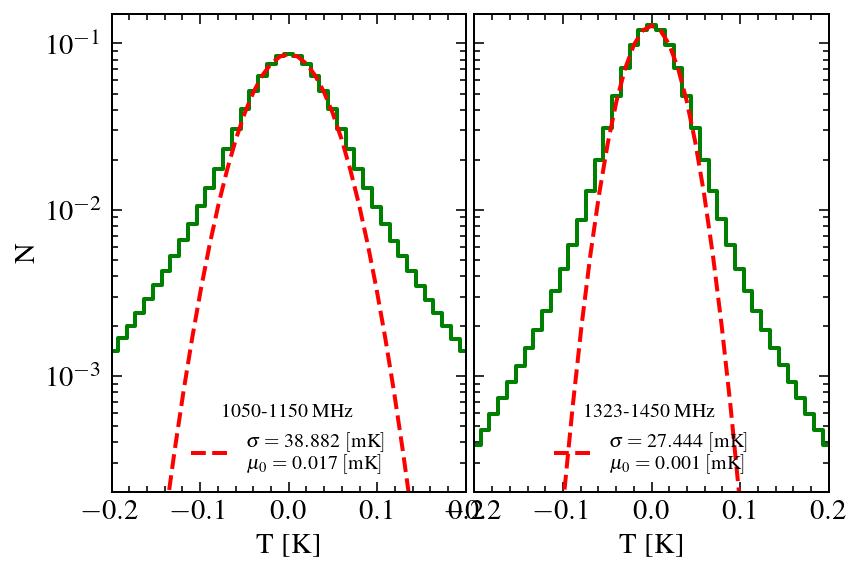

In [39]:
map_path = '/home/DATA/ycli/fanalysis/map_df28k_2021/'
map_name = 'cm_Combined_1050-1150MHz.h5'

freq_diff = 'ABAB'
results_map_ABAB_l, bc_map, be_map = tsys.check_tsys_map(map_path, [map_name, ], freq_diff, 
                                                         freq_sel=slice(0, None)) 

map_path = '/home/DATA/ycli/fanalysis/map_df28k_2021/'
map_name = 'cm_Combined_1250-1450MHz.h5'

freq_diff = 'ABAB'
results_map_ABAB_h, bc_map, be_map = tsys.check_tsys_map(map_path, [map_name, ], freq_diff, 
                                                         freq_sel=slice(2500, None)) 

r_map_l, r_map_h = tsys.plot_rms_hist_low_and_high_band(results_map_ABAB_l, results_map_ABAB_h, 
                                                        bc_map, bc_map, be_map, be_map, 
                                                        freq_diff=freq_diff, xlim=(-0.2, 0.2), 
                                                        ylim=(2.e-4, 1.5e-1), 
                                                        output_name='plot/rms_map.png')

Main:   0%|          | 0/1 [00:00<?, ?it/s]

Main:   0%|          | 0/1 [00:00<?, ?it/s]

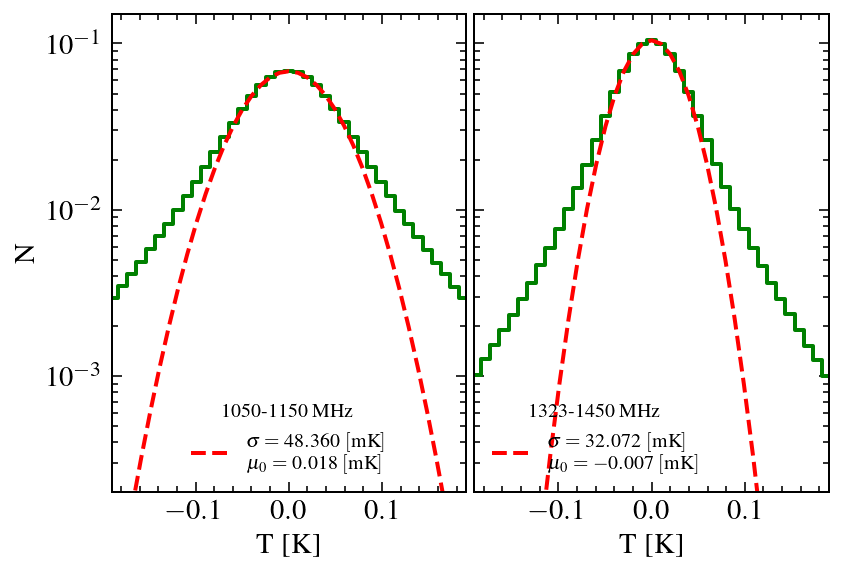

In [43]:
#freq_mask_l = None
#freq_mask_h = None

map_path = '/home/DATA/ycli/fanalysis/map_df28k_2021/'
map_name = 'cm_Combined_1050-1150MHz.h5'

freq_diff = 'ABAB'
results_map_ABAB_l, bc_map, be_map = tsys.check_tsys_map(map_path, [map_name, ], freq_diff, 
                                                         freq_sel=slice(0, None),
                                                         freq_mask=freq_mask_l) 

map_path = '/home/DATA/ycli/fanalysis/map_df28k_2021/'
map_name = 'cm_Combined_1250-1450MHz.h5'

freq_diff = 'ABAB'
results_map_ABAB_h, bc_map, be_map = tsys.check_tsys_map(map_path, [map_name, ], freq_diff, 
                                                         freq_sel=slice(2500, None),
                                                         freq_mask=freq_mask_h)

r_map_l, r_map_h = tsys.plot_rms_hist_low_and_high_band(results_map_ABAB_l, results_map_ABAB_h, 
                                                        bc_map, bc_map, be_map, be_map, 
                                                        freq_diff=freq_diff, xlim=(-0.19, 0.19), 
                                                        ylim=(2.e-4, 1.5e-1), 
                                                        output_name='plot/rms_map_maskfreq.png')

Main:   0%|          | 0/1 [00:00<?, ?it/s]

Freq:   0%|          | 0/819 [00:00<?, ?it/s]

Main:   0%|          | 0/1 [00:00<?, ?it/s]

Freq:   0%|          | 0/1013 [00:00<?, ?it/s]

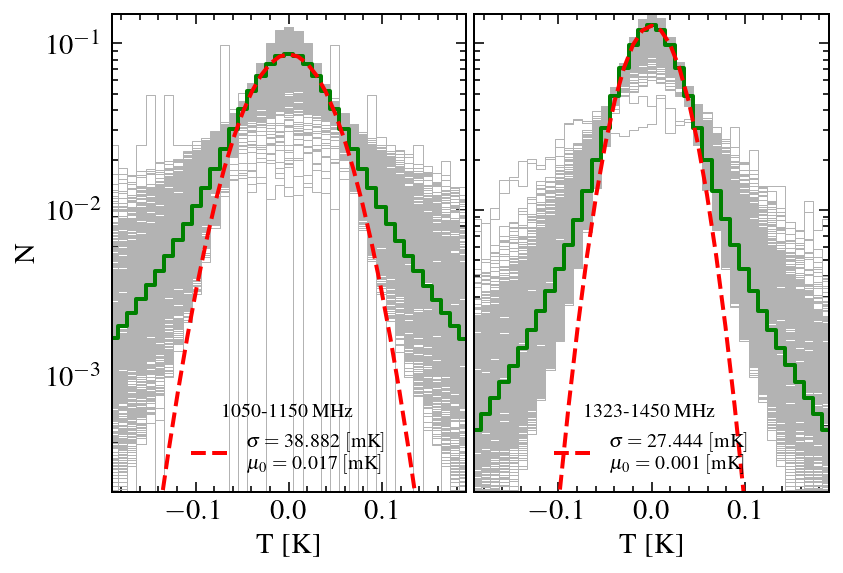

In [44]:
map_path = '/home/DATA/ycli/fanalysis/map_df28k_2021/'
map_name = 'cm_Combined_1050-1150MHz.h5'

freq_diff = 'ABAB'
results_map_ABAB_l, bc_map, be_map = tsys.check_tsys_map(map_path, [map_name, ], freq_diff, 
                                                         freq_sel=slice(0, None),
                                                         freq_mask=None, per_freq=True) 

map_path = '/home/DATA/ycli/fanalysis/map_df28k_2021/'
map_name = 'cm_Combined_1250-1450MHz.h5'

freq_diff = 'ABAB'
results_map_ABAB_h, bc_map, be_map = tsys.check_tsys_map(map_path, [map_name, ], freq_diff, 
                                                         freq_sel=slice(2500, None),
                                                         freq_mask=None, per_freq=True)

r_map_l, r_map_h = tsys.plot_rms_hist_low_and_high_band(results_map_ABAB_l[0], results_map_ABAB_h[0], 
                                                        bc_map, bc_map, be_map, be_map, 
                                                        freq_diff=freq_diff, xlim=(-0.19, 0.19), 
                                                        ylim=(2.e-4, 1.5e-1), 
                                                        output_name='plot/rms_map.png')

Main:   0%|          | 0/1 [00:00<?, ?it/s]

Freq:   0%|          | 0/819 [00:00<?, ?it/s]

Main:   0%|          | 0/1 [00:00<?, ?it/s]

Freq:   0%|          | 0/1013 [00:00<?, ?it/s]

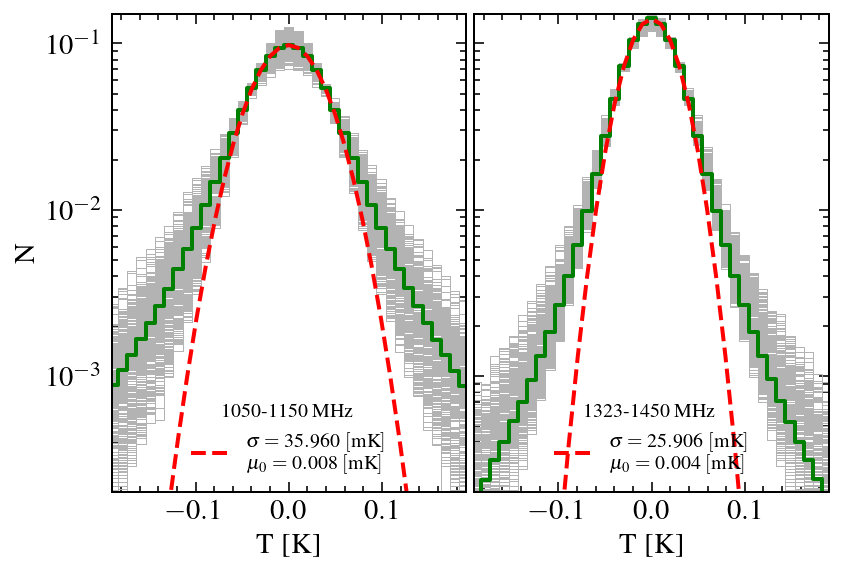

In [62]:
#freq_mask_l = None
#freq_mask_h = None

map_path = '/home/DATA/ycli/fanalysis/map_df28k_2021/'
map_name = 'cm_Combined_1050-1150MHz.h5'

freq_diff = 'ABAB'
results_map_ABAB_l, bc_map, be_map = tsys.check_tsys_map(map_path, [map_name, ], freq_diff, 
                                                         freq_sel=slice(0, None),
                                                         freq_mask=freq_mask_l, per_freq=True) 

map_path = '/home/DATA/ycli/fanalysis/map_df28k_2021/'
map_name = 'cm_Combined_1250-1450MHz.h5'

freq_diff = 'ABAB'
results_map_ABAB_h, bc_map, be_map = tsys.check_tsys_map(map_path, [map_name, ], freq_diff, 
                                                         freq_sel=slice(2500, None),
                                                         freq_mask=freq_mask_h, per_freq=True)

r_map_l, r_map_h = tsys.plot_rms_hist_low_and_high_band(results_map_ABAB_l[0], results_map_ABAB_h[0], 
                                                        bc_map, bc_map, be_map, be_map, 
                                                        freq_diff=freq_diff, xlim=(-0.19, 0.19), 
                                                        ylim=(2.e-4, 1.5e-1), 
                                                        output_name='plot/rms_map_maskfreq.png')

## Sensitivity

$T = \frac{\lambda^2}{2k_{\rm B}\Omega} S $, $\Omega = \frac{\pi \theta_{\rm fwhm}^2}{4 \ln 2}$

In [58]:
sigma_per_pix = 25.9 # mK

mJy2K = flux_tod.mJy2K(1.400)

n_freq = 50.e6 / 28.e3
sigma_per_pix = sigma_per_pix * 1.e-3 / mJy2K / (n_freq)**0.5

print(sigma_per_pix)

0.02992434718566592


In [57]:
sigma_per_pix = 2.36 # mK

mJy2K = flux_tod.mJy2K(1.400)

sigma_per_pix = sigma_per_pix * 1.e-3 / mJy2K #/ (n_freq)**0.5

print(sigma_per_pix)

0.11522399006118865


In [61]:
sigma_per_pix = 42.4 # mK

mJy2K = flux_tod.mJy2K(1.400)

n_freq = 50.e6 / 30.e3
sigma_per_pix = sigma_per_pix * 1.e-3 / mJy2K / (n_freq)**0.5

print(sigma_per_pix)

0.05070752214984379


## Confusion limit

Condon J.~J., 1974, ApJ, 188, 279. doi:10.1086/152714

$\sigma \approx 0.2 \left(\frac{\nu}{\rm GHz}\right)^{-0.7}\left(\frac{\theta_{\rm fwhm}}{\rm arcmin}\right)^2$

In [2]:
sigma_conf = 0.2 * 1.4**(-0.7) * 3.**2
print(sigma_conf, 'mJy/beam')
print(sigma_conf * 10, 'mJy/beam')

1.4222727200828473 mJy/beam
14.222727200828473 mJy/beam


## CHIPASS map

In [17]:
chipass_path = '/home/DATA/ycli/chipass/'
chipass_name = 'lambda_chipass_healpix_r10.fits'

chipass = hp.read_map(chipass_path + chipass_name)
mask = ( chipass < -1.1e10 ) + (chipass > 1.1e10)

In [18]:
r = hp.Rotator(coord=['G', 'C'])
chipass_C = r.rotate_map_pixel(chipass)

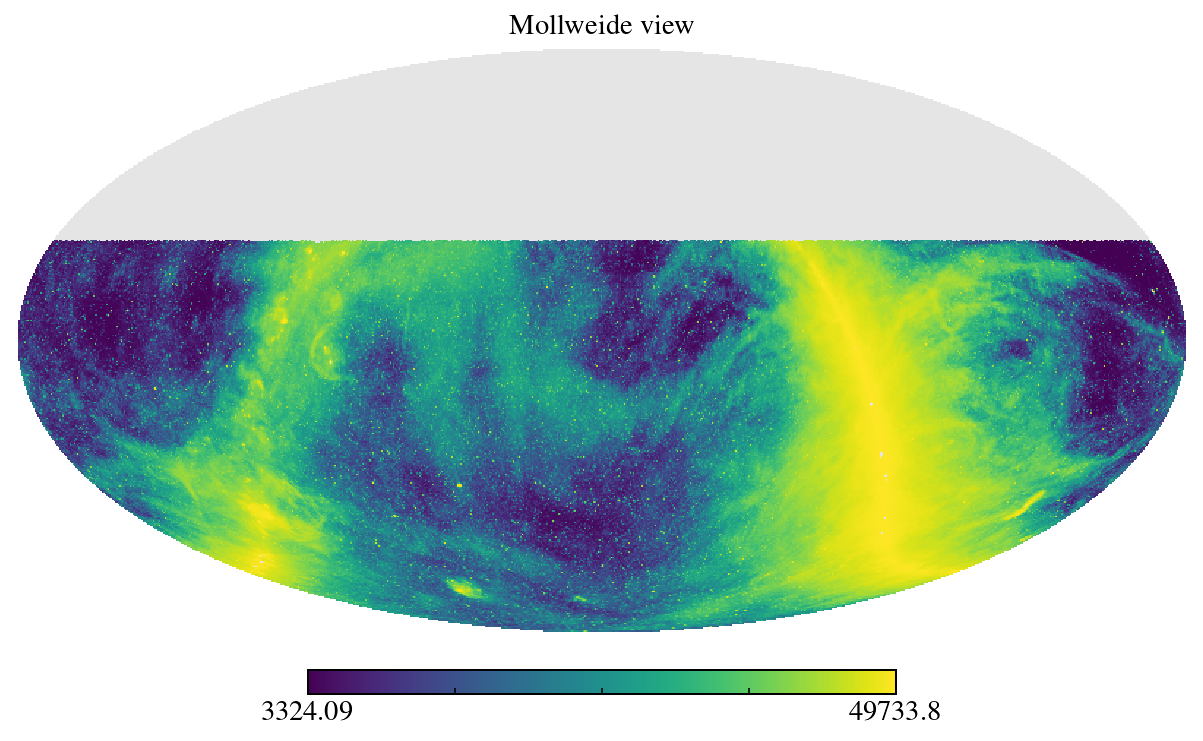

In [19]:
mask = ( chipass_C < -1.1e10 ) + (chipass_C > 1.1e10)
#chipass = np.ma.array(chipass, mask=mask)
chipass_C[mask] = hp.UNSEEN
chipass_C = hp.ma(chipass_C)
hp.mollview(chipass_C, badcolor='0.9', norm='hist')

In [20]:
pix = np.arange(chipass_C.shape[0])
nside = hp.npix2nside(chipass_C.shape[0])
pix_ra, pix_dec = hp.pix2ang(nside=nside, ipix = pix, lonlat=True)

In [21]:
print(pix_dec[~mask].max(), pix_dec[~mask].min())

25.695845714932346 -89.77157305148222


True
7851.318478133713 3332.624196369363
3690.185347432914


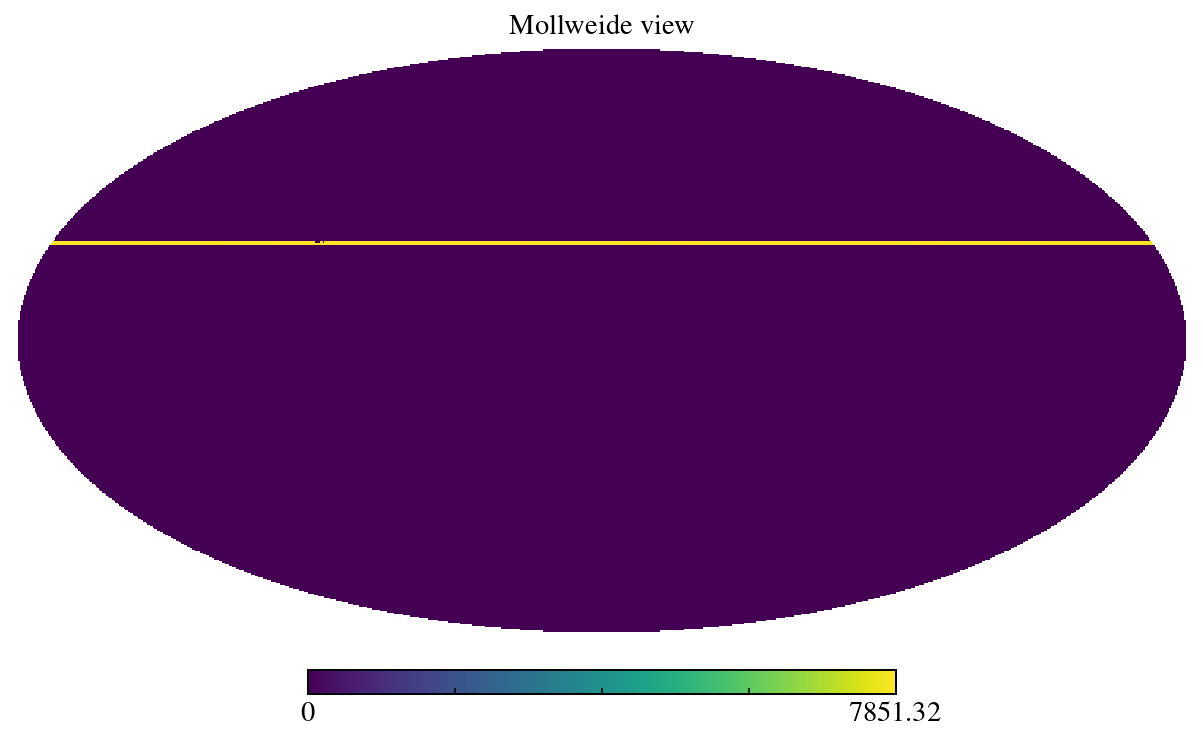

In [24]:
good = ( pix_dec > 24.0 ) * ( pix_dec < 25.) #* (pix_ra < 13*15) * (pix_ra > 9*15)
print(np.any(good))
chipass_C_mask = chipass_C.copy()
chipass_C_mask[~good] = 0
chipass_C_mask = np.ma.masked_equal(chipass_C_mask, 0)
hp.mollview(chipass_C_mask, badcolor='0.9', norm='hist')
print(chipass_C_mask.max(), chipass_C_mask.min())
print(np.ma.mean(chipass_C_mask))

In [77]:
Tsys = 20 #99. * (2 * 28e3 * 1)**0.5 * 1.e-3
Tsky = 3.5
Tcmb = 2.73
Trec = 9.

In [78]:
print(Tsys - Tsky - Tcmb - Trec)

4.77


In [3]:
import pygsm

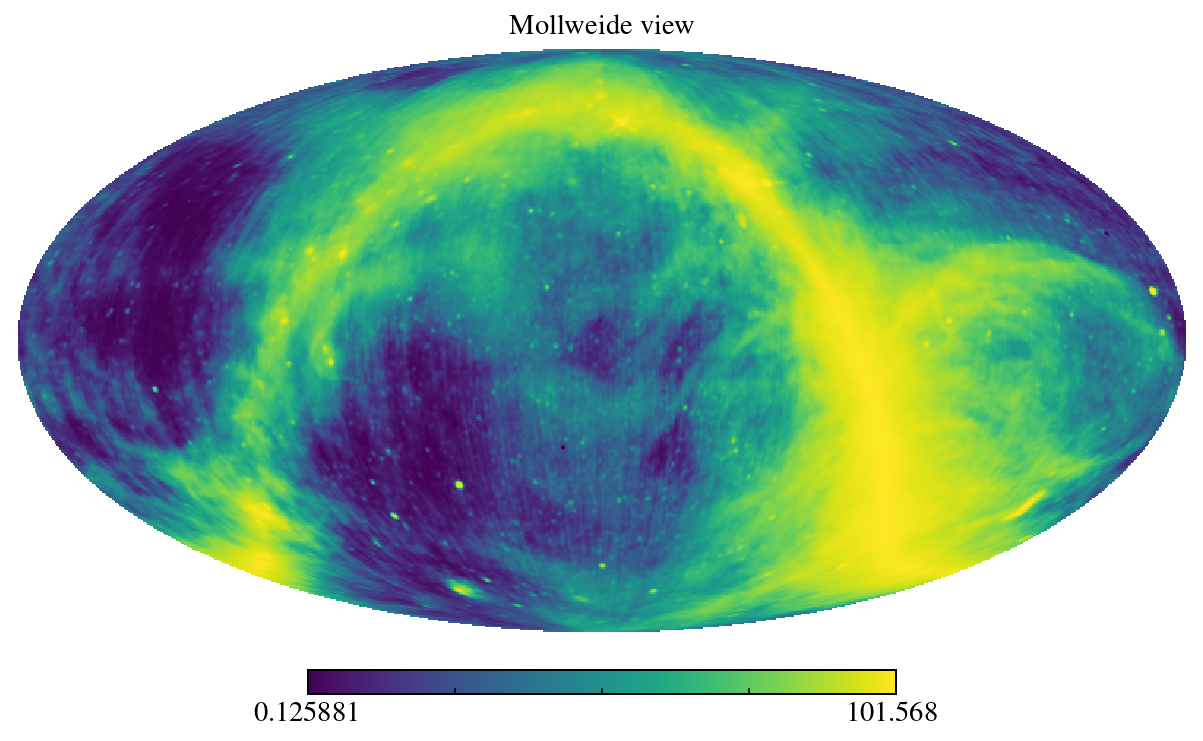

In [9]:
r   = hp.Rotator(coord=['G', 'C'])
GSM = pygsm.GlobalSkyModel(freq_unit='MHz',basemap='haslam')
syn_model = r.rotate_map_pixel(GSM.generate(1400).T)
hp.mollview(syn_model, norm='hist')

In [11]:
pix = np.arange(syn_model.shape[0])
nside = hp.npix2nside(syn_model.shape[0])
pix_ra, pix_dec = hp.pix2ang(nside=nside, ipix = pix, lonlat=True)
good = ( pix_dec > 25.0 ) * ( pix_dec < 27.0) * (pix_ra < 13*15) * (pix_ra > 9*15)

0.6929430042620099 0.15431623837545405
0.5062438477759514


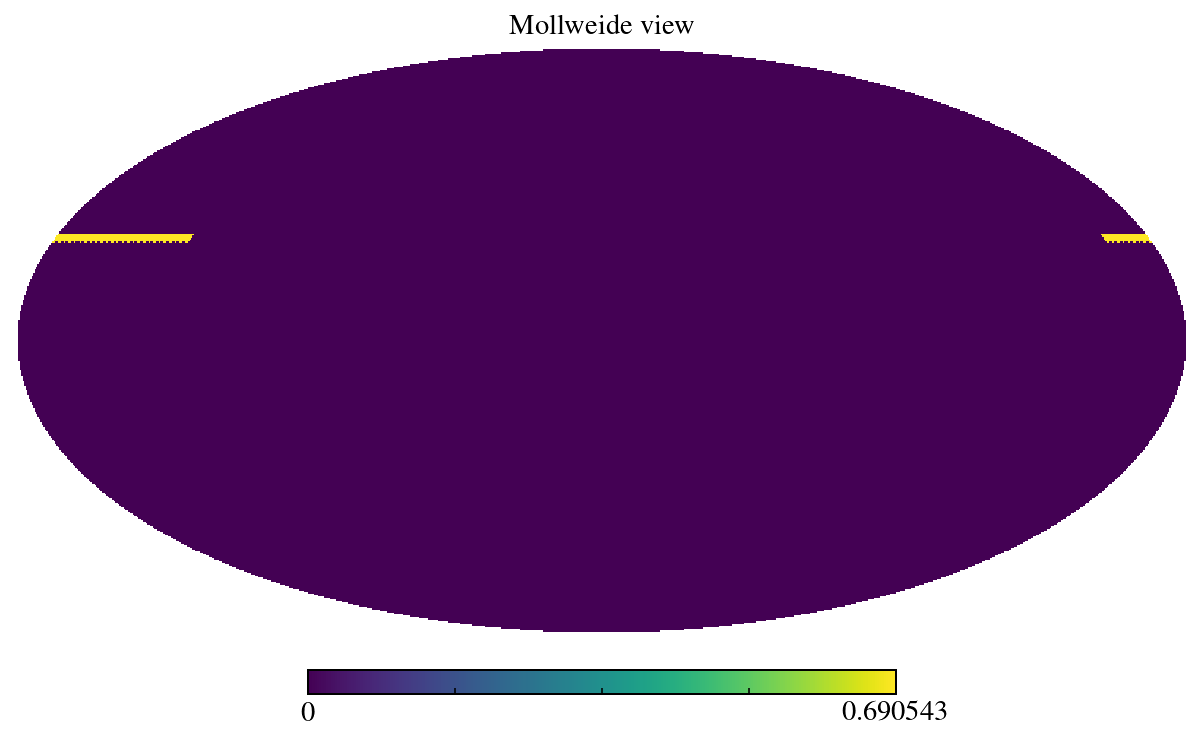

In [12]:
chipass_C_mask = syn_model.copy()
chipass_C_mask[~good] = 0
chipass_C_mask = np.ma.masked_equal(chipass_C_mask, 0)
hp.mollview(chipass_C_mask, badcolor='0.9', norm='hist')
print(chipass_C_mask.max(), chipass_C_mask.min())
print(np.ma.mean(chipass_C_mask))